# 🌊 Water Segmentation from Satellite Images using Deep Learning

## 📌 Project Overview
This project aims to segment water bodies from multi-band satellite images using deep learning (U-Net). It includes preprocessing, visualization, and training using 12-band geospatial imagery.

## 📂 Dataset Details
- **Inputs**: 12-band `.tif` satellite images
- **Labels**: Binary `.png` masks (water = 1, non-water = 0)
- **Bands**: Includes Blue, Green, Red, NIR, SWIR, etc.

## 🧪 Goals
- Visualize spectral composites (true/false color, NDWI)
- Use NDWI and spectral indices to generate dynamic water masks
- Train a U-Net segmentation model
- Evaluate using IoU, F1-score, and losses
- Visualize training progress with line charts

## 📌 Key Features
✅ Band selection & normalization  
✅ NDWI & custom spectral logic for mask creation  
✅ Albumentations for data augmentation  
✅ PyTorch U-Net for semantic segmentation  
✅ Metric logging (IoU, F1, losses)  
✅ Visual diagnostics (RGB, NDWI, prediction maps)

## 🛠️ Project Structure

| Section                  | Description                                |
|--------------------------|--------------------------------------------|
| 📁 Data Loading          | Load and pair image/mask files             |
| 🖼️ Visualization         | Explore band combinations and NDWI         |
| 🧹 Preprocessing         | Normalize, resize, augment                 |
| 📦 Dataset & Dataloader | Custom PyTorch Dataset implementation      |
| 🧠 Model                 | U-Net segmentation architecture            |
| 🏋️ Training Loop        | Train and validate model over epochs       |
| 📈 Metrics & Charts      | Plot F1, IoU, and loss over time           |

## 📉 Metrics Tracked
- Train/Validation Loss  
- F1-Score  
- IoU (Intersection over Union)

## 📊 Output Visualizations
- RGB & false color composites  
- NDWI and custom band masks  
- Predicted masks vs ground truth  
- Line charts for metrics over epochs


In [1]:
!pip install -U rasterio segmentation-models-pytorch mlflow pyngrok --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 51.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.7/24.7 MB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 75.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 67.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66

# 📦 Setup and Importing Libraries

- Loads essential libraries for the project, covering:
  - **File handling & image processing**: `os`, `cv2`, `tifffile`, `rasterio`
  - **Machine learning & deep learning**: `torch`, `torchvision`, `sklearn`
  - **Data augmentation**: `albumentations`
  - **Visualization**: `matplotlib`
  - **Progress tracking**: `tqdm`

These libraries support reading satellite images, building datasets, training models, and visualizing results.


In [10]:
# 📁 File system and image handling
import os
import random
from glob import glob
import tifffile as tiff
import cv2
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from scipy.stats import pearsonr


from typing import List, Optional, Callable ,Tuple


# 🔁 Machine learning and deep learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import segmentation_models_pytorch as smp  # Make sure it's installed


# 📊 Evaluation and metrics
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

# 🔄 Data augmentation and preprocessing
import albumentations as A
from albumentations.pytorch import ToTensorV2

# ⏳ Progress bar for training loops
from tqdm import tqdm

import mlflow
import mlflow.pytorch





def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 🔍 Visualizing Random Satellite Samples and Band Combinations

- Randomly selects and visualizes 5 satellite image samples.
- Displays multiple spectral composites and analysis views:
  - **True Color** (RGB: Bands 2-1-0)
  - **False Color** (RGB: Bands 7-3-2) – highlights vegetation/water
  - **NDWI** – emphasizes water bodies using Green and NIR
  - **Custom Mask** – derived from Blue, NIR, SWIR with thresholding
  - **SWIR-NIR-Blue Composite** – false RGB-like visual from Bands 5-3-0
  - **Ground Truth Mask** – binary segmentation labels

Useful for verifying spectral separability of water regions before model training.


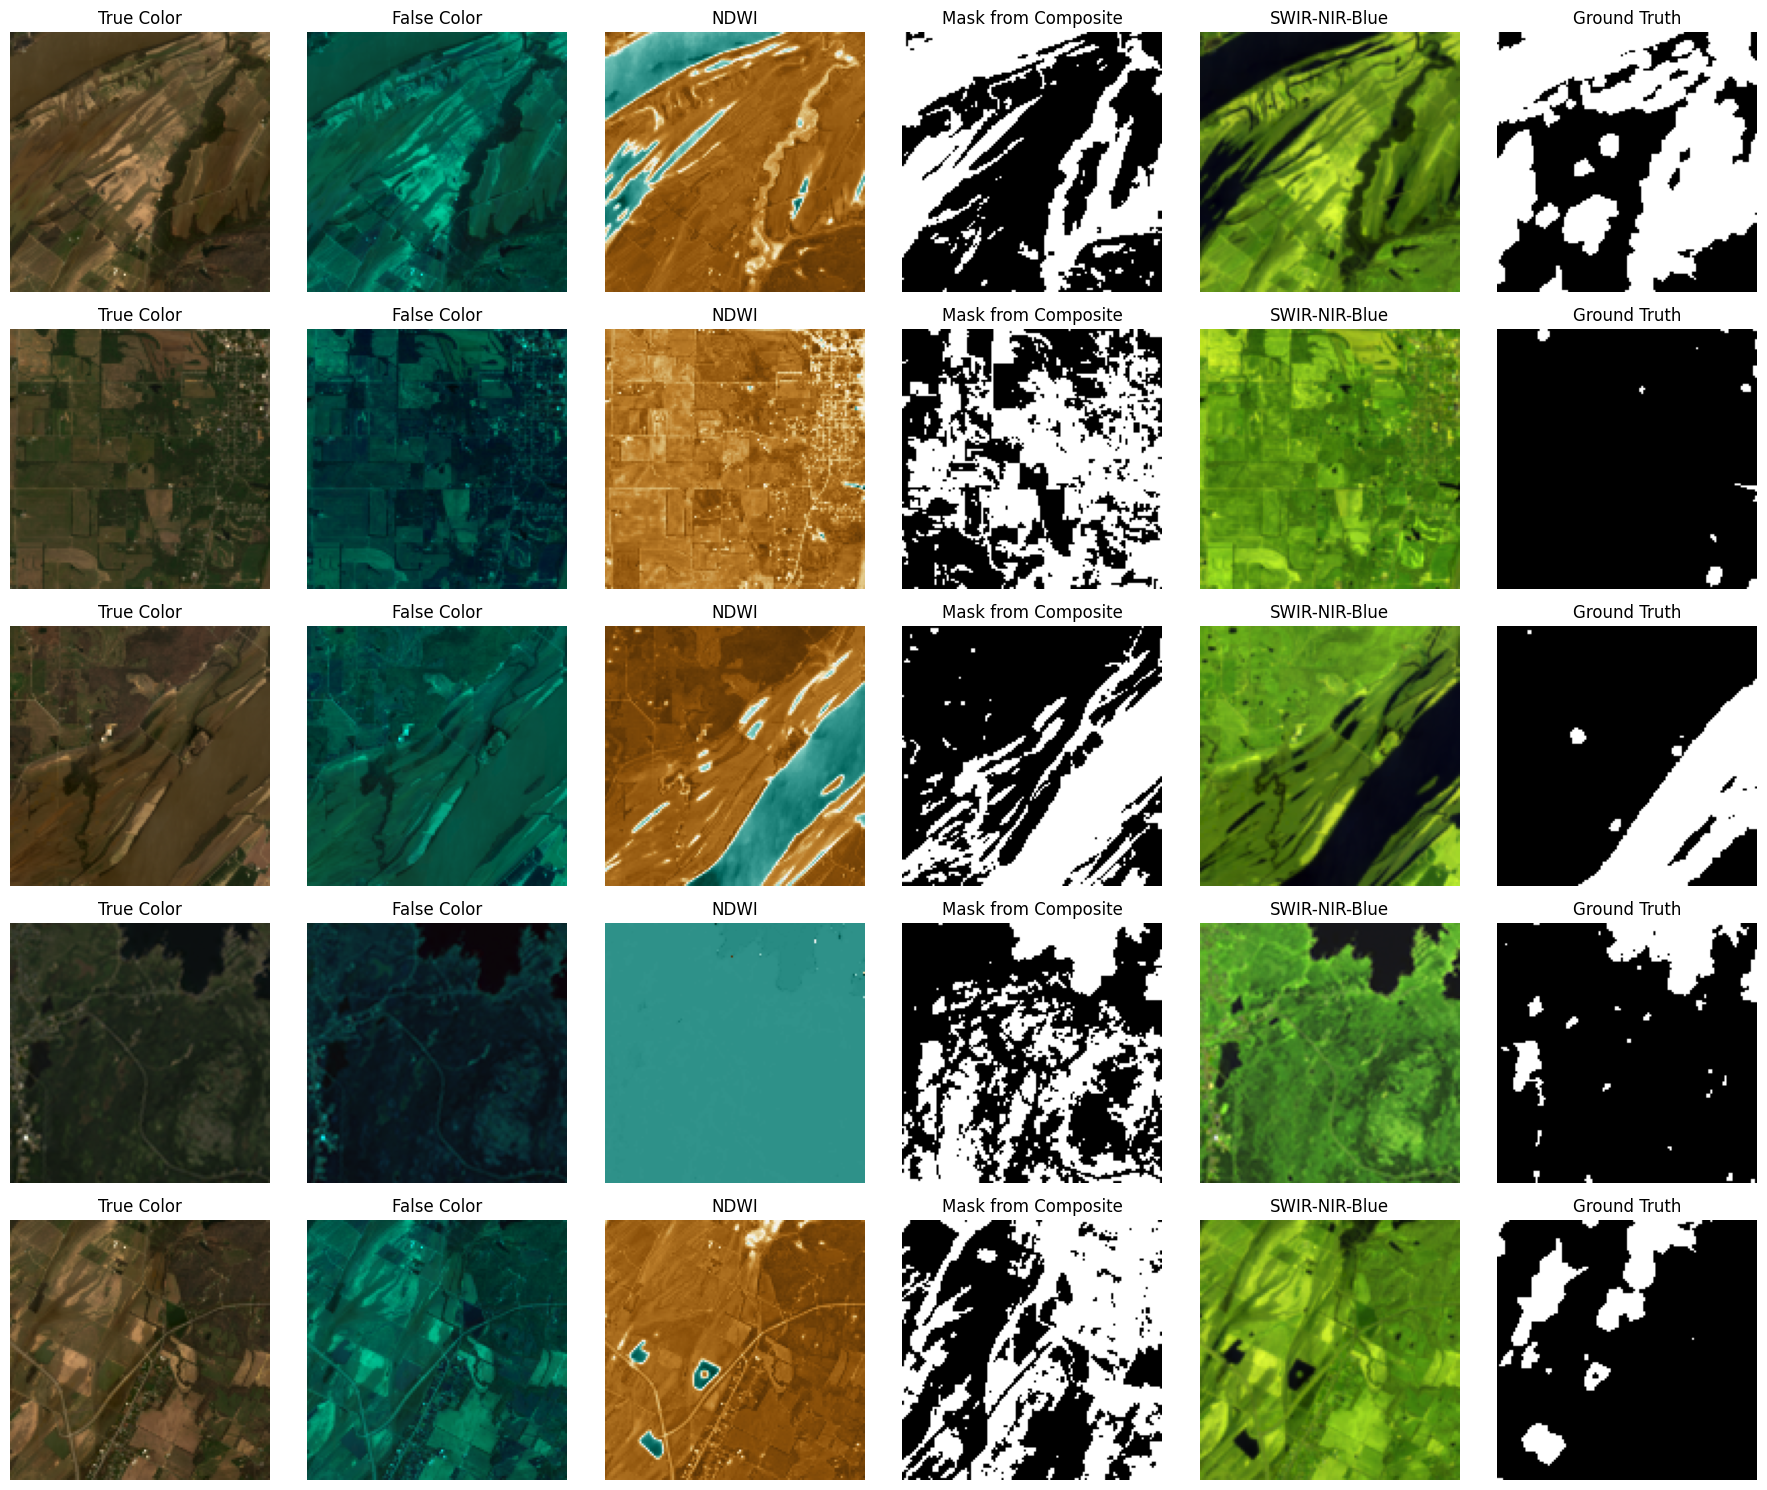

In [4]:
# Load paths
image_paths = sorted(glob("/content/drive/MyDrive/Water Segmentation/data/images/*.tif"))
label_paths = sorted(glob("/content/drive/MyDrive/Water Segmentation/data/labels/*.png"))

# Match by base filename
image_dict = {os.path.splitext(os.path.basename(p))[0]: p for p in image_paths}
label_dict = {os.path.splitext(os.path.basename(p))[0]: p for p in label_paths}
common_keys = sorted(set(image_dict.keys()) & set(label_dict.keys()))
matched_image_paths = [image_dict[k] for k in common_keys]
matched_label_paths = [label_dict[k] for k in common_keys]

# Random sample
num_samples = 5
random_indices = random.sample(range(len(matched_image_paths)), num_samples)

plt.figure(figsize=(18, num_samples * 3))

for row, idx in enumerate(random_indices):
    image = tiff.imread(matched_image_paths[idx])
    label = cv2.imread(matched_label_paths[idx], cv2.IMREAD_GRAYSCALE)

    # ----- True Color: R=Band4, G=Band3, B=Band2 -----
    rgb = image[:, :, [3, 2, 1]].astype(np.float32)
    rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min() + 1e-8)
    plt.subplot(num_samples, 6, row * 6 + 1)
    plt.imshow(rgb)
    plt.title("True Color")
    plt.axis("off")

    # ----- False Color: R=Band8 (SWIR), G=Band4 (Red), B=Band3 (Green) -----
    false_color = image[:, :, [7, 3, 2]].astype(np.float32)
    false_color = (false_color - false_color.min()) / (false_color.max() - false_color.min() + 1e-10)
    plt.subplot(num_samples, 6, row * 6 + 2)
    plt.imshow(false_color)
    plt.title("False Color")
    plt.axis("off")

    # ----- NDWI: Green=Band4, NIR=Band7 -----
    green = image[:, :, 2].astype(np.float32)
    nir = image[:, :, 5].astype(np.float32)
    ndwi = (green - nir) / (green + nir + 1e-8)
    plt.subplot(num_samples, 6, row * 6 + 3)
    plt.imshow(ndwi, cmap='BrBG')
    plt.title("NDWI")
    plt.axis("off")

    # ----- Custom Mask from Blue + NIR + SWIR -----
    blue = image[:, :, 0].astype(np.float32)   # Band2
    nir = image[:, :, 5].astype(np.float32)    # Band7
    swir = image[:, :, 6].astype(np.float32)   # Band8

    composite = np.stack([swir, nir, blue], axis=2)
    composite_norm = (composite - composite.min()) / (composite.max() - composite.min() + 1e-8)
    gray = composite_norm.mean(axis=2)

    # ----- RGB Composite (SWIR-NIR-Blue) -----
    plt.subplot(num_samples, 6, row * 6 + 5)
    plt.imshow(composite_norm)
    plt.title("SWIR-NIR-Blue")
    plt.axis("off")

    # ----- Threshold-based mask -----
    threshold = np.mean(gray) - 0.1 * np.std(gray)
    custom_mask = gray < threshold
    plt.subplot(num_samples, 6, row * 6 + 4)
    plt.imshow(custom_mask, cmap='gray')
    plt.title("Mask from Composite")
    plt.axis("off")

    # ----- Ground Truth -----
    plt.subplot(num_samples, 6, row * 6 + 6)
    plt.imshow(label, cmap='gray')
    plt.title("Ground Truth")
    plt.axis("off")

plt.tight_layout()
plt.show()


# 📊 Plotting the 12 Spectral Bands
- Visualizes all 12 input bands from one image in the validation dataset.
- Each band is displayed in grayscale to observe patterns and distributions.
- Helps inspect differences in brightness, texture, and signal range between bands.


In [5]:
# Print the shape of the image (Height x Width x Bands)
print("Image shape:", image.shape)

# Print the shape of the label (Height x Width)
print("Label shape:", label.shape)

# Print the unique values in the label mask (should typically be 0 and 1 for binary segmentation)
print("Unique label values:", np.unique(label))


Image shape: (128, 128, 12)
Label shape: (128, 128)
Unique label values: [0 1]


# 🧾 WaterSegmentationDataset Summary

- Custom PyTorch `Dataset` for loading 12-band multispectral images and binary masks.
- Supports optional Albumentations transforms for data augmentation.
- Returns image and mask tensors in shapes `(12, H, W)` and `(1, H, W)` respectively.
- Designed for water segmentation tasks in satellite imagery.


In [6]:
class WaterSegmentationDataset(Dataset):
    def __init__(
        self,
        image_paths: List[str],
        mask_paths: List[str],
        transform: Optional[Callable] = None,
        selected_bands: Optional[List[int]] = None,
    ):
        """
        image_paths: list of paths to multispectral images
        mask_paths: list of paths to corresponding masks
        transform: optional albumentations transform applied to image and mask
        selected_bands: list of band indices to use (1-based, e.g., [1, 2, 4]).
                        If None, all bands are used.
        """
        assert len(image_paths) == len(mask_paths), "Image and mask list lengths must match."
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform
        self.selected_bands = selected_bands

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load the multispectral image
        with rasterio.open(self.image_paths[idx]) as src:
            if self.selected_bands:
                image = src.read(self.selected_bands)  # (C, H, W)
            else:
                image = src.read()  # (C, H, W)

        # Load mask as grayscale and binarize
        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)
        if mask is None:
            raise FileNotFoundError(f"Mask not found or could not be read: {self.mask_paths[idx]}")
        mask = (mask > 0).astype(np.uint8)  # Binary mask

        # Convert image from (C, H, W) to (H, W, C) and ensure float32
        image = np.transpose(image, (1, 2, 0)).astype(np.float32)  # (H, W, C)

        # Min-Max normalization per band
        min_vals = image.min(axis=(0, 1), keepdims=True)  # shape (1, 1, C)
        max_vals = image.max(axis=(0, 1), keepdims=True)
        range_vals = max_vals - min_vals
        range_vals[range_vals == 0] = 1  # Prevent division by zero
        image = (image - min_vals) / range_vals

        # Apply transforms (Albumentations expects HWC)
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']            # Expected (C, H, W)
            mask = augmented['mask'].unsqueeze(0)  # (1, H, W)
        else:
            image = torch.tensor(image, dtype=torch.float).permute(2, 0, 1)  # (C, H, W)
            mask = torch.tensor(mask, dtype=torch.float).unsqueeze(0)        # (1, H, W)

        return image, mask


In [7]:
def compute_band_mask_similarity(image_path: str, mask_path: str, bands: List[int]) -> List[float]:
    """
    Compute similarity (Pearson correlation) between each band and the mask.
    If either is constant, return 0 similarity.
    """
    with rasterio.open(image_path) as src:
        image = src.read(bands)  # (C, H, W)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        raise FileNotFoundError(f"Mask not found: {mask_path}")
    mask = (mask > 0).astype(np.uint8)

    mask_flat = mask.flatten()
    similarities = []

    for i in range(image.shape[0]):
        band = image[i]
        band_flat = band.flatten()

        # Check if band or mask is constant
        if np.std(band_flat) == 0 or np.std(mask_flat) == 0:
            similarities.append(0.0)
        else:
            corr, _ = pearsonr(band_flat, mask_flat)
            if np.isnan(corr):
                similarities.append(0.0)
            else:
                similarities.append(abs(corr))  # Take absolute value for ranking

    return similarities


In [8]:
def select_top_k_bands(
    image_paths: List[str],
    mask_paths: List[str],
    all_bands: List[int],
    top_k: int = 3
) -> Tuple[List[int], List[float]]:
    """
    Rank bands by average similarity to masks and return top-k most relevant.
    Also prints the similarity score for each band.
    """
    band_similarities = np.zeros(len(all_bands))
    count = 0

    for img_path, mask_path in zip(image_paths, mask_paths):
        sims = compute_band_mask_similarity(img_path, mask_path, all_bands)
        band_similarities += np.array(sims)
        count += 1

    avg_similarities = band_similarities / count
    ranked_indices = np.argsort(avg_similarities)[::-1]  # Descending
    top_bands = [all_bands[i] for i in ranked_indices[:top_k]]

    print("\n📊 Band Similarity Scores:")
    for i in ranked_indices:
        print(f"Band {all_bands[i]}: {avg_similarities[i]:.4f}")

    return top_bands, avg_similarities.tolist()


In [11]:
all_bands = list(range(1, 13))  # 12 bands
top_bands, sim_scores = select_top_k_bands(image_paths[:306], label_paths[:306], all_bands, top_k=8)

print("\n✅ Selected Top Bands:", top_bands)



📊 Band Similarity Scores:
Band 5: 0.4133
Band 6: 0.4058
Band 12: 0.3783
Band 7: 0.3672
Band 9: 0.3308
Band 10: 0.3040
Band 11: 0.2802
Band 8: 0.2527
Band 1: 0.1902
Band 3: 0.1643
Band 2: 0.1592
Band 4: 0.1578

✅ Selected Top Bands: [5, 6, 12, 7, 9, 10, 11, 8]


### 🧪 `train_transform` – Data Augmentation Pipeline

This Albumentations pipeline is used to augment training images and masks to improve model generalization.

In [14]:

image_dict = {os.path.splitext(os.path.basename(p))[0]: p for p in image_paths}
label_dict = {os.path.splitext(os.path.basename(p))[0]: p for p in label_paths}

common_keys = sorted(set(image_dict.keys()) & set(label_dict.keys()))

matched_images = [image_dict[k] for k in common_keys]
matched_labels = [label_dict[k] for k in common_keys]

print(f"Total matched pairs: {len(matched_images)}")

Total matched pairs: 306


In [15]:
# Split the matched image and mask pairs into training and validation sets (80% train, 20% val)

train_imgs, val_imgs, train_labels, val_labels = train_test_split(
    matched_images, matched_labels, test_size=0.2, random_state=42
)

print(f"Train: {len(train_imgs)} | Val: {len(val_imgs)}")


Train: 244 | Val: 62


# 🧹 Dataset & DataLoader Configuration

- #️⃣ Creates PyTorch-compatible datasets using `WaterSegmentationDataset`.
- 📊 `train_dataset` and `val_dataset` are initialized with image and mask paths.
- ⚙️ No data augmentation (`transform=None`) at this stage.
- 🚚 `DataLoader` wraps each dataset for batch processing:
  - `train_loader`: Batches of 4, data shuffled for training.
  - `val_loader`: Batches of 4, no shuffling for consistent validation.

This setup ensures efficient batch-wise training and validation of the segmentation model.


In [16]:
train_dataset = dataset = WaterSegmentationDataset(train_imgs, train_labels, transform=None, selected_bands=None)
val_dataset   = dataset = WaterSegmentationDataset(val_imgs, val_labels, transform=None, selected_bands=None)

batch_size =32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True )
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


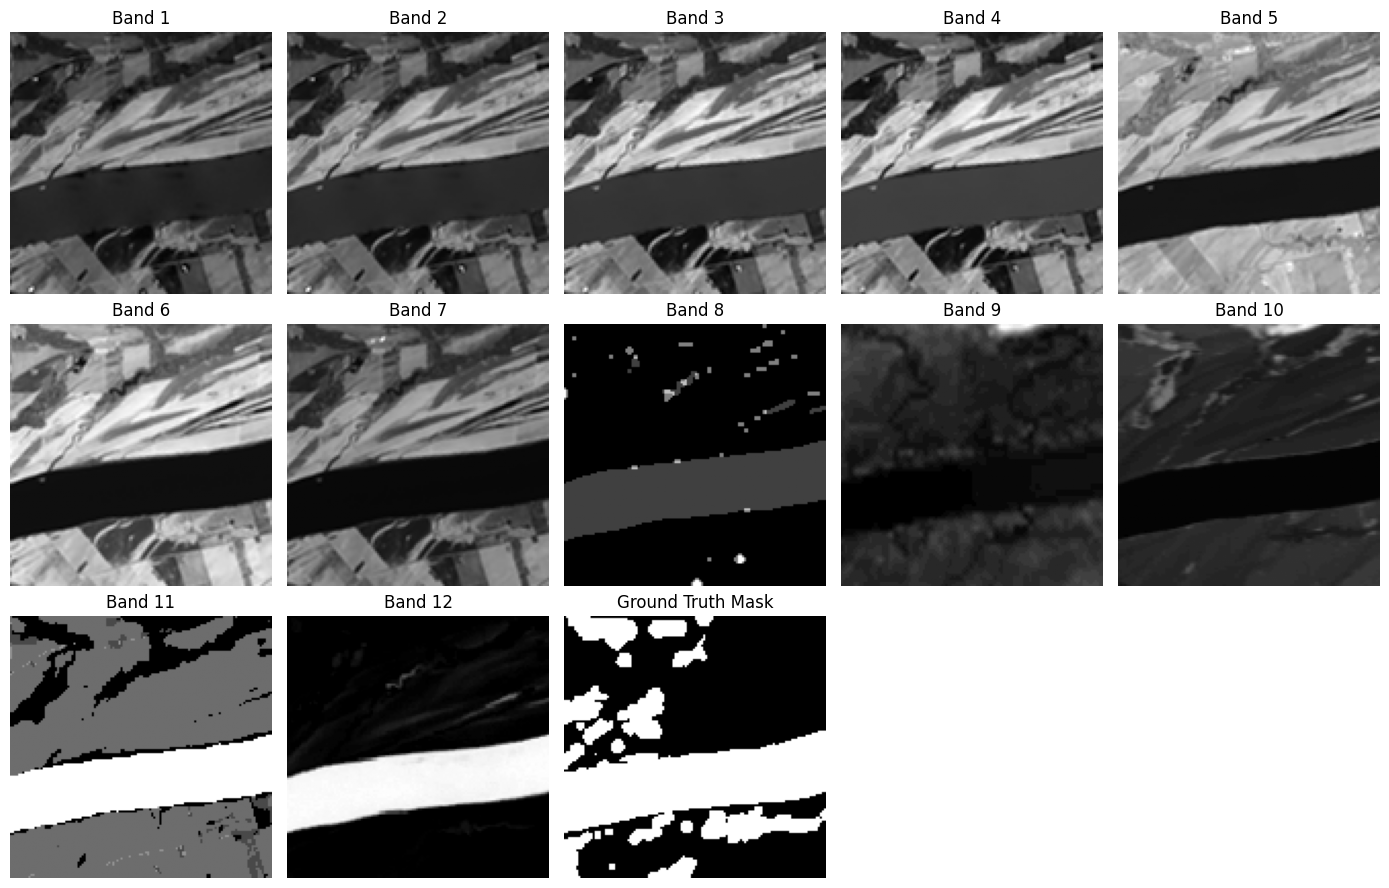

In [17]:
# Function to visualize all 12 bands of a single image + its mask
def plot_12_band_image_with_mask(image_tensor, mask_tensor):
    """
    Displays all 12 bands from an image along with its corresponding mask.
    Input image shape: (12, H, W)
    Input mask shape: (1, H, W) or (H, W)
    """
    # Convert tensors to numpy arrays
    if isinstance(image_tensor, torch.Tensor):
        image_tensor = image_tensor.cpu().numpy()
    if isinstance(mask_tensor, torch.Tensor):
        mask_tensor = mask_tensor.cpu().numpy()
        if mask_tensor.ndim == 3:
            mask_tensor = mask_tensor[0]  # Remove channel dim if exists

    # Plot 12 bands + 1 mask (total 13 subplots)
    plt.figure(figsize=(14, 9))
    for i in range(12):
        plt.subplot(3, 5, i + 1)
        plt.imshow(image_tensor[i], cmap='gray')
        plt.title(f'Band {i+1}')
        plt.axis('off')

    # Plot the mask at the end
    plt.subplot(3, 5, 13)
    plt.imshow(mask_tensor, cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Display the image and its mask from the first batch of validation set
for images, masks in val_loader:
    plot_12_band_image_with_mask(images[10], masks[10])
    break


In [18]:
def print_band_statistics(image_tensor):
    """
    Print mean, median, std, min, max for each of the 12 bands.
    image_tensor: torch.Tensor or np.ndarray of shape (12, H, W)
    """
    if isinstance(image_tensor, torch.Tensor):
        image_tensor = image_tensor.cpu().numpy()

    print("=== Band Statistics ===")
    for i in range(12):
        band = image_tensor[i]
        mean_val = band.mean()
        median_val = np.median(band)
        std_val = band.std()
        min_val = band.min()
        max_val = band.max()

        print(f"Band {i+1:>2}: Mean={mean_val:.4f} | Median={median_val:.4f} | Std={std_val:.4f} | Min={min_val:.4f} | Max={max_val:.4f}")

# Example usage on a sample from val_loader
for images, masks in val_loader:
    print_band_statistics(images[1])
    break


=== Band Statistics ===
Band  1: Mean=0.1654 | Median=0.1511 | Std=0.0491 | Min=0.0000 | Max=1.0000
Band  2: Mean=0.1223 | Median=0.1060 | Std=0.0560 | Min=0.0000 | Max=1.0000
Band  3: Mean=0.1318 | Median=0.1167 | Std=0.0648 | Min=0.0000 | Max=1.0000
Band  4: Mean=0.1487 | Median=0.1187 | Std=0.0844 | Min=0.0000 | Max=1.0000
Band  5: Mean=0.3829 | Median=0.4206 | Std=0.1545 | Min=0.0000 | Max=1.0000
Band  6: Mean=0.4275 | Median=0.4328 | Std=0.2160 | Min=0.0000 | Max=1.0000
Band  7: Mean=0.3423 | Median=0.3152 | Std=0.1981 | Min=0.0000 | Max=1.0000
Band  8: Mean=0.0791 | Median=0.0000 | Std=0.1791 | Min=0.0000 | Max=1.0000
Band  9: Mean=0.1765 | Median=0.1860 | Std=0.1077 | Min=0.0000 | Max=1.0000
Band 10: Mean=0.2126 | Median=0.2222 | Std=0.1183 | Min=0.0000 | Max=1.0000
Band 11: Mean=0.4300 | Median=0.4286 | Std=0.2978 | Min=0.0000 | Max=1.0000
Band 12: Mean=0.1484 | Median=0.0000 | Std=0.3424 | Min=0.0000 | Max=1.0000


# 🧹 Dataset & DataLoader Configuration

## 📁 Dataset Construction
- Uses `WaterSegmentationDataset` class to handle satellite `.tif` images and segmentation masks.
- `selected_bands` argument allows manual selection of specific spectral bands.
- Normalization is applied per band using:
  \[
  \text{normalized} = \frac{x - \min(x)}{\max(x) - \min(x) + 1e-8}
  \]

## 🎨 Data Augmentation
- Training data is augmented using `albumentations`:
  - Resize to 256×256
  - Horizontal & Vertical Flip
  - Random 90° Rotation
  - Shift, Scale, Rotate
  - Convert to PyTorch tensors with `ToTensorV2()`
- Validation data only resized and converted to tensor (no augmentation).

## 🚚 DataLoader Setup
- `train_loader_aug`:
  - Batch size: 8  
  - Shuffling: ✅ Enabled
- `val_loader_aug`:
  - Batch size: 8  
  - Shuffling: ❌ Disabled

# ✅ Purpose
- Ensures efficient training on normalized, multi-band satellite images.
- Augmentation enhances generalization during training.
- Validation is consistent and reproducible with fixed transforms.


In [63]:
# Define selected bands (None means use all 12 bands)
selected_bands = [5, 6, 12, 7, 9, 10, 11, 8]  # Blue, Green, NIR




# ✅ Albumentations Transforms

train_transform = A.Compose([
    A.Resize(128, 128),
    A.HorizontalFlip(p=0.3),
    A.VerticalFlip(p=0.3),
    A.RandomRotate90(p=0.3),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=10, p=0.3),
    A.RandomBrightnessContrast(p=0.3),
    A.RandomGamma(p=0.3),
    A.GaussianBlur(p=0.2),
    A.GaussNoise(var_limit=(5.0, 20.0), p=0.2),
    A.CoarseDropout(max_holes=4, max_height=16, max_width=16, min_holes=1, fill_value=0, p=0.2),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(128, 128),
    ToTensorV2()
])

train_dataset_aug = WaterSegmentationDataset(
    image_paths=train_imgs,
    mask_paths=train_labels,
    transform=None,
    selected_bands=selected_bands,



)

val_dataset_aug = WaterSegmentationDataset(
    image_paths=val_imgs,
    mask_paths=val_labels,
    transform=None,
    selected_bands=selected_bands,


)


train_loader_aug = DataLoader(train_dataset_aug, batch_size=32, shuffle=True, num_workers=2)
val_loader_aug = DataLoader(val_dataset_aug, batch_size=32, shuffle=False, num_workers=2)

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipython-input-439721040.py:18: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5.0, 20.0), p=0.2),
/tmp/ipython-input-439721040.py:19: UserWarning: Argument(s) 'max_holes, max_height, max_width, min_holes, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=4, max_height=16, max_width=16, min_holes=1, fill_value=0, p=0.2),


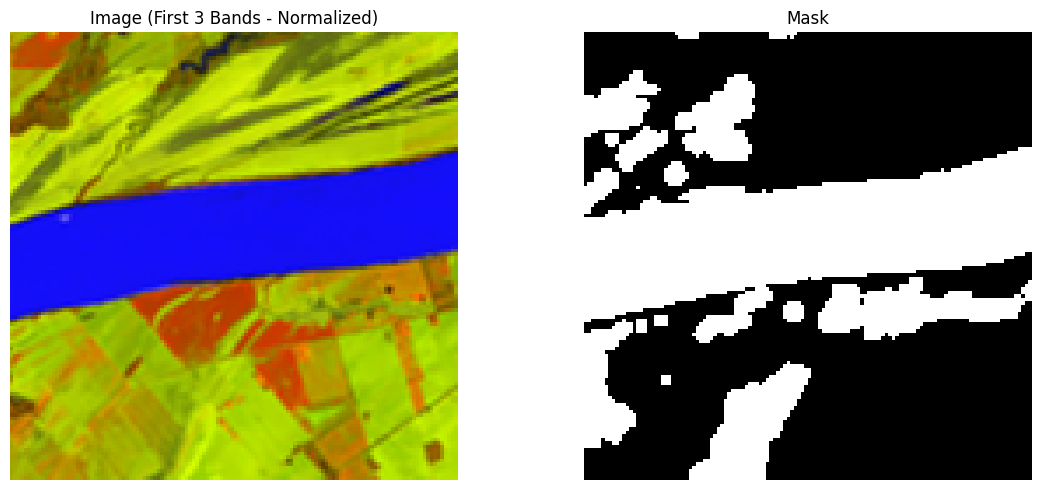

In [65]:
import random
import matplotlib.pyplot as plt

def show_random_sample(dataset):
    idx = random.randint(0, len(dataset) - 1)
    image_tensor, mask_tensor = dataset[idx]

    image_np = image_tensor.permute(1, 2, 0).numpy()  # (H, W, C)
    mask_np = mask_tensor.squeeze().numpy()

    # Normalize for visualization
    image_vis = image_np[:, :, :3]  # أول 3 قنوات فقط للعرض
    image_vis = (image_vis - image_vis.min()) / (image_vis.max() - image_vis.min() + 1e-8)

    # Plot
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    if image_np.shape[2] >= 3:
        plt.imshow(image_vis)
        plt.title(f"Image (First 3 Bands - Normalized)")
    else:
        plt.imshow(image_np[:, :, 0], cmap='gray')
        plt.title("Image (1st Band)")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(mask_np, cmap='gray')
    plt.title("Mask")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# ✅ Call the function
show_random_sample(train_dataset_aug)


In [46]:
image_tensor, mask_tensor = val_dataset_aug[5]

print("Image shape:", image_tensor.shape)
print("Mask shape :", mask_tensor.shape)

Image shape: torch.Size([8, 128, 128])
Mask shape : torch.Size([1, 128, 128])


In [47]:
def print_band_statistics(image_tensor):
    """
    Print mean, median, std, min, max for each of the 12 bands.
    image_tensor: torch.Tensor or np.ndarray of shape (12, H, W)
    """
    if isinstance(image_tensor, torch.Tensor):
        image_tensor = image_tensor.cpu().numpy()

    print("=== Band Statistics ===")
    for i in range(8):
        band = image_tensor[i]
        mean_val = band.mean()
        median_val = np.median(band)
        std_val = band.std()
        min_val = band.min()
        max_val = band.max()

        print(f"Band {i+1:>2}: Mean={mean_val:.4f} | Median={median_val:.4f} | Std={std_val:.4f} | Min={min_val:.4f} | Max={max_val:.4f}")

# Example usage on a sample from val_loader
for images, masks in val_loader_aug:
    print_band_statistics(images[1])
    break


=== Band Statistics ===
Band  1: Mean=0.3829 | Median=0.4206 | Std=0.1545 | Min=0.0000 | Max=1.0000
Band  2: Mean=0.4275 | Median=0.4328 | Std=0.2160 | Min=0.0000 | Max=1.0000
Band  3: Mean=0.1484 | Median=0.0000 | Std=0.3424 | Min=0.0000 | Max=1.0000
Band  4: Mean=0.3423 | Median=0.3152 | Std=0.1981 | Min=0.0000 | Max=1.0000
Band  5: Mean=0.1765 | Median=0.1860 | Std=0.1077 | Min=0.0000 | Max=1.0000
Band  6: Mean=0.2126 | Median=0.2222 | Std=0.1183 | Min=0.0000 | Max=1.0000
Band  7: Mean=0.4300 | Median=0.4286 | Std=0.2978 | Min=0.0000 | Max=1.0000
Band  8: Mean=0.0791 | Median=0.0000 | Std=0.1791 | Min=0.0000 | Max=1.0000


# 🏋️ Training and Evaluation Functions

- 🔁 `train_one_epoch`: Handles one full training pass through the dataset using forward and backward propagation to optimize the model.

- 🧪 `evaluate`: Assesses model performance on the validation set without updating weights, calculating:
  - 📉 Validation Loss
  - 🧮 IoU (Intersection over Union)
  - 🎯 Accuracy
  - 💠 F1-Score

These functions form the core loop for training and validating the segmentation model.


In [23]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    epoch_loss = 0

    for images, masks in tqdm(dataloader):
        images = images.to(device)
        masks = masks.to(device).float()

        # التمرير الأمامي
        outputs = model(images)
        loss = criterion(outputs, masks)

        # التمرير الخلفي والتحديث
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(dataloader)


def evaluate(model, dataloader, criterion, device):
    model.eval()
    val_loss = 0
    total_iou = 0
    total_acc = 0
    total_f1 = 0
    num_batches = 0

    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device).float()

            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()

            # Apply sigmoid then threshold
            preds = torch.sigmoid(outputs)
            preds = (preds > 0.5).float()

            # Flatten predictions and masks
            preds_flat = preds.view(-1).cpu()
            masks_flat = masks.view(-1).cpu()

            # IoU
            intersection = (preds_flat * masks_flat).sum()
            union = preds_flat.sum() + masks_flat.sum() - intersection
            iou = (intersection / union).item() if union > 0 else 0
            total_iou += iou

            # Accuracy
            correct = (preds_flat == masks_flat).sum().item()
            total = masks_flat.numel()
            acc = correct / total
            total_acc += acc

            # F1 Score
            f1 = f1_score(masks_flat.numpy(), preds_flat.numpy(), zero_division=1)
            total_f1 += f1

            num_batches += 1

    avg_loss = val_loss / num_batches
    avg_iou = total_iou / num_batches
    avg_acc = total_acc / num_batches
    avg_f1 = total_f1 / num_batches

    return avg_loss, avg_iou, avg_acc, avg_f1



# 🧠 U-Net Architecture for Water Segmentation

Defines the U-Net model with the following components:

- 🔽 **Encoder**: Series of convolutional blocks and pooling layers to extract hierarchical features.
- 🔁 **Bottleneck**: Dense layer connecting encoder and decoder.
- 🔼 **Decoder**: Upsampling layers and skip connections for spatial reconstruction.
- 🎯 **Output Layer**: 1×1 convolution to map to binary mask logits.

Input: 12-band satellite image  
Output: Raw segmentation logits (before sigmoid)


In [24]:
class DoubleConv(nn.Module):
    """[Conv2D => BatchNorm => ReLU] * 2"""
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=12, out_channels=1):
        super(UNet, self).__init__()

        # Encoder
        self.down1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.down3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.down4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = DoubleConv(512, 1024)

        # Decoder
        self.up1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec1 = DoubleConv(1024, 512)

        self.up2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec2 = DoubleConv(512, 256)

        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec3 = DoubleConv(256, 128)

        self.up4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec4 = DoubleConv(128, 64)

        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        d1 = self.down1(x)
        d2 = self.down2(self.pool1(d1))
        d3 = self.down3(self.pool2(d2))
        d4 = self.down4(self.pool3(d3))

        # Bottleneck
        bn = self.bottleneck(self.pool4(d4))

        # Decoder
        up1 = self.up1(bn)
        up1 = torch.cat([up1, d4], dim=1)
        dec1 = self.dec1(up1)

        up2 = self.up2(dec1)
        up2 = torch.cat([up2, d3], dim=1)
        dec2 = self.dec2(up2)

        up3 = self.up3(dec2)
        up3 = torch.cat([up3, d2], dim=1)
        dec3 = self.dec3(up3)

        up4 = self.up4(dec3)
        up4 = torch.cat([up4, d1], dim=1)
        dec4 = self.dec4(up4)

        return self.final_conv(dec4)  # raw logits


In [25]:
# Define your tracking directory on Google Drive
tracking_dir = "/content/drive/MyDrive/mlruns"

# 💡 Ensure the tracking directory exists
#os.makedirs(tracking_dir, exist_ok=True)

# Set MLflow to use this directory
mlflow.set_tracking_uri(f"file://{tracking_dir}")

# Set or create an experiment
mlflow.set_experiment("UNet_Baseline")

2025/08/01 18:32:19 INFO mlflow.tracking.fluent: Experiment with name 'UNet_Baseline' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///content/drive/MyDrive/mlruns/325963355761506248', creation_time=1754073139895, experiment_id='325963355761506248', last_update_time=1754073139895, lifecycle_stage='active', name='UNet_Baseline', tags={}>

In [26]:
from rasterio.errors import NotGeoreferencedWarning
import warnings

# Suppress NotGeoreferencedWarning
warnings.filterwarnings("ignore", category=NotGeoreferencedWarning)

num_epochs =50
in_channels = 12
lr=1e-4
out_channels=1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_model = UNet(in_channels=in_channels, out_channels=out_channels).to(device)
optimizer = torch.optim.Adam(base_model.parameters(), lr=lr)
criterion = nn.BCEWithLogitsLoss()

mlflow.set_experiment("UNet_Baseline")           # Create or use

<Experiment: artifact_location='file:///content/drive/MyDrive/mlruns/325963355761506248', creation_time=1754073139895, experiment_id='325963355761506248', last_update_time=1754073139895, lifecycle_stage='active', name='UNet_Baseline', tags={}>

# 🚀 Model Training Loop

This section handles the training process for 50 epochs:

- ⚙️ **Model Setup**: Initializes U-Net, optimizer (Adam), and loss function (BCEWithLogits).
- 🧠 **Training + Evaluation**: Each epoch trains on the training set and evaluates on the validation set.
- 📊 **Metric Tracking**: Saves loss, IoU, and F1 scores across epochs for visualization or analysis.


In [27]:

# Start logging
with mlflow.start_run(run_name="Unet") as run:

    # Log the model
    #mlflow.pytorch.log_model(base_model, "model")

    # Save model architecture to text
    with open("model_architecture.txt", "w") as f:
        f.write(str(base_model))

    # Log architecture file as artifact
    mlflow.log_artifact("model_architecture.txt")


    # Log parameters
    mlflow.log_param("model", "UNet_Baseline")
    mlflow.log_param("in_channels", in_channels)
    mlflow.log_param("out_channels", 1)
    mlflow.log_param("epochs", num_epochs)
    mlflow.log_param("learning_rate", 1e-4)
    mlflow.log_param("Bands", 'All')
    mlflow.log_param("Norm", 'Min_Max')
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("loss_fn", "BCEWithLogitsLoss")
    mlflow.log_param("encoder_weights", "None")
    mlflow.log_param("augmentation" , "None")
    #mlflow.log_param("augmentation", "albumentations: HorizontalFlip, VerticalFlip, RandomRotate90, ShiftScaleRotate, Resize(256x256)")



    train_losses = []
    val_losses = []
    val_ious = []
    val_f1s = []

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        train_loss = train_one_epoch(base_model, train_loader, optimizer, criterion, device)
        val_loss, val_iou, val_acc, val_f1 = evaluate(base_model, val_loader, criterion, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_ious.append(val_iou)
        val_f1s.append(val_f1)

        # Log metrics
        mlflow.log_metric("train_loss", train_loss, step=epoch)
        mlflow.log_metric("val_loss", val_loss, step=epoch)
        mlflow.log_metric("val_iou", val_iou, step=epoch)
        mlflow.log_metric("val_f1", val_f1, step=epoch)

        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | IoU: {val_iou:.4f} | F1: {val_f1:.4f}")

    # Log final model
    mlflow.pytorch.log_model(base_model, "model")




Epoch 1/50


100%|██████████| 8/8 [00:07<00:00,  1.08it/s]


Train Loss: 0.5656 | Val Loss: 0.6678 | IoU: 0.0000 | F1: 0.0000

Epoch 2/50


100%|██████████| 8/8 [00:06<00:00,  1.29it/s]


Train Loss: 0.4345 | Val Loss: 0.5929 | IoU: 0.0136 | F1: 0.0268

Epoch 3/50


100%|██████████| 8/8 [00:06<00:00,  1.18it/s]


Train Loss: 0.3992 | Val Loss: 0.4878 | IoU: 0.3248 | F1: 0.4902

Epoch 4/50


100%|██████████| 8/8 [00:07<00:00,  1.13it/s]


Train Loss: 0.3674 | Val Loss: 0.3810 | IoU: 0.5772 | F1: 0.7296

Epoch 5/50


100%|██████████| 8/8 [00:06<00:00,  1.27it/s]


Train Loss: 0.3458 | Val Loss: 0.3313 | IoU: 0.6893 | F1: 0.8149

Epoch 6/50


100%|██████████| 8/8 [00:06<00:00,  1.21it/s]


Train Loss: 0.3318 | Val Loss: 0.3339 | IoU: 0.6645 | F1: 0.7960

Epoch 7/50


100%|██████████| 8/8 [00:06<00:00,  1.20it/s]


Train Loss: 0.3186 | Val Loss: 0.3031 | IoU: 0.7098 | F1: 0.8291

Epoch 8/50


100%|██████████| 8/8 [00:06<00:00,  1.27it/s]


Train Loss: 0.3116 | Val Loss: 0.3271 | IoU: 0.6771 | F1: 0.8074

Epoch 9/50


100%|██████████| 8/8 [00:06<00:00,  1.21it/s]


Train Loss: 0.3038 | Val Loss: 0.2943 | IoU: 0.7301 | F1: 0.8429

Epoch 10/50


100%|██████████| 8/8 [00:06<00:00,  1.28it/s]


Train Loss: 0.3003 | Val Loss: 0.2633 | IoU: 0.7271 | F1: 0.8408

Epoch 11/50


100%|██████████| 8/8 [00:06<00:00,  1.23it/s]


Train Loss: 0.2927 | Val Loss: 0.2573 | IoU: 0.7455 | F1: 0.8535

Epoch 12/50


100%|██████████| 8/8 [00:06<00:00,  1.22it/s]


Train Loss: 0.2795 | Val Loss: 0.2605 | IoU: 0.7451 | F1: 0.8531

Epoch 13/50


100%|██████████| 8/8 [00:06<00:00,  1.28it/s]


Train Loss: 0.2750 | Val Loss: 0.2610 | IoU: 0.7479 | F1: 0.8548

Epoch 14/50


100%|██████████| 8/8 [00:06<00:00,  1.21it/s]


Train Loss: 0.2758 | Val Loss: 0.2696 | IoU: 0.7553 | F1: 0.8600

Epoch 15/50


100%|██████████| 8/8 [00:06<00:00,  1.27it/s]


Train Loss: 0.2735 | Val Loss: 0.2461 | IoU: 0.7623 | F1: 0.8647

Epoch 16/50


100%|██████████| 8/8 [00:06<00:00,  1.24it/s]


Train Loss: 0.2590 | Val Loss: 0.2640 | IoU: 0.7513 | F1: 0.8577

Epoch 17/50


100%|██████████| 8/8 [00:06<00:00,  1.20it/s]


Train Loss: 0.2495 | Val Loss: 0.2486 | IoU: 0.7734 | F1: 0.8718

Epoch 18/50


100%|██████████| 8/8 [00:06<00:00,  1.25it/s]


Train Loss: 0.2407 | Val Loss: 0.2358 | IoU: 0.7689 | F1: 0.8687

Epoch 19/50


100%|██████████| 8/8 [00:06<00:00,  1.19it/s]


Train Loss: 0.2429 | Val Loss: 0.2299 | IoU: 0.7738 | F1: 0.8721

Epoch 20/50


100%|██████████| 8/8 [00:06<00:00,  1.23it/s]


Train Loss: 0.2433 | Val Loss: 0.2240 | IoU: 0.7788 | F1: 0.8753

Epoch 21/50


100%|██████████| 8/8 [00:06<00:00,  1.27it/s]


Train Loss: 0.2320 | Val Loss: 0.2290 | IoU: 0.7818 | F1: 0.8771

Epoch 22/50


100%|██████████| 8/8 [00:06<00:00,  1.18it/s]


Train Loss: 0.2313 | Val Loss: 0.2304 | IoU: 0.7845 | F1: 0.8790

Epoch 23/50


100%|██████████| 8/8 [00:06<00:00,  1.28it/s]


Train Loss: 0.2296 | Val Loss: 0.2198 | IoU: 0.7972 | F1: 0.8869

Epoch 24/50


100%|██████████| 8/8 [00:06<00:00,  1.23it/s]


Train Loss: 0.2161 | Val Loss: 0.2181 | IoU: 0.7886 | F1: 0.8815

Epoch 25/50


100%|██████████| 8/8 [00:06<00:00,  1.21it/s]


Train Loss: 0.2140 | Val Loss: 0.2162 | IoU: 0.8036 | F1: 0.8910

Epoch 26/50


100%|██████████| 8/8 [00:06<00:00,  1.20it/s]


Train Loss: 0.2032 | Val Loss: 0.2135 | IoU: 0.8056 | F1: 0.8922

Epoch 27/50


100%|██████████| 8/8 [00:06<00:00,  1.20it/s]


Train Loss: 0.2007 | Val Loss: 0.2017 | IoU: 0.8084 | F1: 0.8938

Epoch 28/50


100%|██████████| 8/8 [00:06<00:00,  1.26it/s]


Train Loss: 0.1980 | Val Loss: 0.2064 | IoU: 0.7866 | F1: 0.8804

Epoch 29/50


100%|██████████| 8/8 [00:06<00:00,  1.26it/s]


Train Loss: 0.1965 | Val Loss: 0.2003 | IoU: 0.8158 | F1: 0.8984

Epoch 30/50


100%|██████████| 8/8 [00:06<00:00,  1.21it/s]


Train Loss: 0.1861 | Val Loss: 0.2047 | IoU: 0.8111 | F1: 0.8956

Epoch 31/50


100%|██████████| 8/8 [00:06<00:00,  1.27it/s]


Train Loss: 0.1832 | Val Loss: 0.1963 | IoU: 0.8153 | F1: 0.8980

Epoch 32/50


100%|██████████| 8/8 [00:07<00:00,  1.14it/s]


Train Loss: 0.1749 | Val Loss: 0.1973 | IoU: 0.8183 | F1: 0.9000

Epoch 33/50


100%|██████████| 8/8 [00:06<00:00,  1.15it/s]


Train Loss: 0.1699 | Val Loss: 0.1912 | IoU: 0.8207 | F1: 0.9014

Epoch 34/50


100%|██████████| 8/8 [00:06<00:00,  1.27it/s]


Train Loss: 0.1785 | Val Loss: 0.1863 | IoU: 0.8159 | F1: 0.8985

Epoch 35/50


100%|██████████| 8/8 [00:06<00:00,  1.17it/s]


Train Loss: 0.1736 | Val Loss: 0.2097 | IoU: 0.7877 | F1: 0.8809

Epoch 36/50


100%|██████████| 8/8 [00:06<00:00,  1.28it/s]


Train Loss: 0.1717 | Val Loss: 0.2085 | IoU: 0.7961 | F1: 0.8863

Epoch 37/50


100%|██████████| 8/8 [00:06<00:00,  1.22it/s]


Train Loss: 0.1687 | Val Loss: 0.1936 | IoU: 0.7948 | F1: 0.8856

Epoch 38/50


100%|██████████| 8/8 [00:06<00:00,  1.21it/s]


Train Loss: 0.1610 | Val Loss: 0.1809 | IoU: 0.8165 | F1: 0.8989

Epoch 39/50


100%|██████████| 8/8 [00:06<00:00,  1.28it/s]


Train Loss: 0.1619 | Val Loss: 0.1911 | IoU: 0.8145 | F1: 0.8976

Epoch 40/50


100%|██████████| 8/8 [00:06<00:00,  1.18it/s]


Train Loss: 0.1584 | Val Loss: 0.1835 | IoU: 0.8220 | F1: 0.9023

Epoch 41/50


100%|██████████| 8/8 [00:06<00:00,  1.26it/s]


Train Loss: 0.1513 | Val Loss: 0.1770 | IoU: 0.8255 | F1: 0.9043

Epoch 42/50


100%|██████████| 8/8 [00:06<00:00,  1.24it/s]


Train Loss: 0.1520 | Val Loss: 0.1743 | IoU: 0.8297 | F1: 0.9069

Epoch 43/50


100%|██████████| 8/8 [00:06<00:00,  1.21it/s]


Train Loss: 0.1460 | Val Loss: 0.1676 | IoU: 0.8265 | F1: 0.9050

Epoch 44/50


100%|██████████| 8/8 [00:06<00:00,  1.24it/s]


Train Loss: 0.1453 | Val Loss: 0.1706 | IoU: 0.8229 | F1: 0.9028

Epoch 45/50


100%|██████████| 8/8 [00:06<00:00,  1.19it/s]


Train Loss: 0.1371 | Val Loss: 0.1625 | IoU: 0.8429 | F1: 0.9147

Epoch 46/50


100%|██████████| 8/8 [00:06<00:00,  1.24it/s]


Train Loss: 0.1392 | Val Loss: 0.1598 | IoU: 0.8280 | F1: 0.9059

Epoch 47/50


100%|██████████| 8/8 [00:06<00:00,  1.27it/s]


Train Loss: 0.1304 | Val Loss: 0.1633 | IoU: 0.8346 | F1: 0.9097

Epoch 48/50


100%|██████████| 8/8 [00:07<00:00,  1.13it/s]


Train Loss: 0.1313 | Val Loss: 0.1622 | IoU: 0.8452 | F1: 0.9161

Epoch 49/50


100%|██████████| 8/8 [00:06<00:00,  1.25it/s]


Train Loss: 0.1255 | Val Loss: 0.1602 | IoU: 0.8468 | F1: 0.9170

Epoch 50/50


100%|██████████| 8/8 [00:06<00:00,  1.20it/s]
2025/08/01 18:39:54 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Train Loss: 0.1217 | Val Loss: 0.1581 | IoU: 0.8464 | F1: 0.9167


2025/08/01 18:39:55 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/08/01 18:40:03 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/08/01 18:40:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [28]:
model_path = "/content/drive/MyDrive/Water Segmentation/models/unet_model.pth"
torch.save(base_model.state_dict(), model_path)
mlflow.log_artifact(model_path)
print("Model saved and logged to MLflow.")


Model saved and logged to MLflow.

























# 📈 Training Performance Visualization

This section plots model performance across epochs:

- **Loss Chart**: Shows training vs. validation loss to monitor overfitting or convergence.
- **IoU & F1 Score Chart**: Visualizes how well the model segments across epochs using Intersection over Union and F1 score.


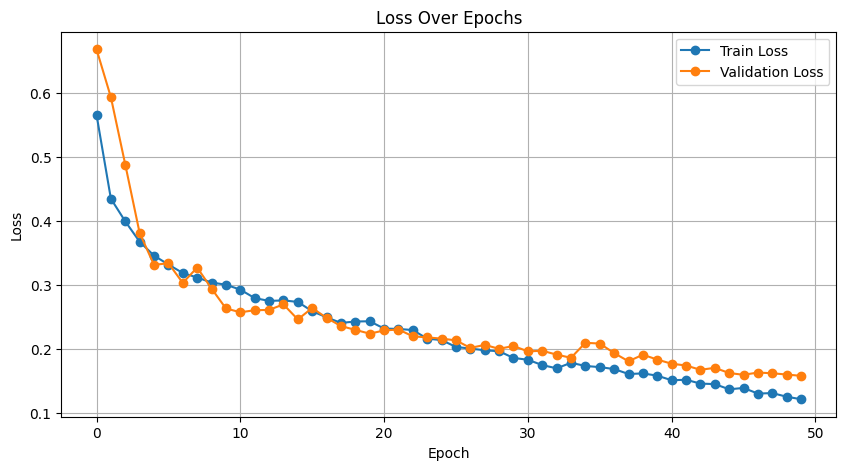

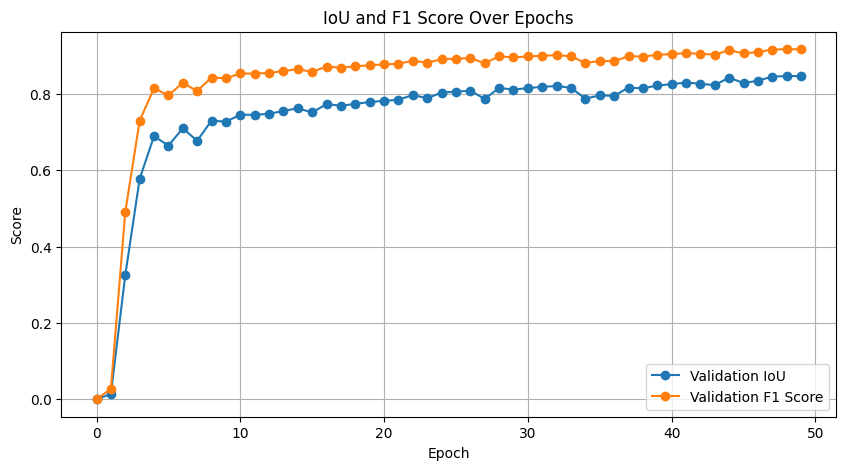

In [29]:
# Loss Chart
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# IoU & F1 Chart
plt.figure(figsize=(10, 5))
plt.plot(val_ious, label='Validation IoU', marker='o')
plt.plot(val_f1s, label='Validation F1 Score', marker='o')
plt.title("IoU and F1 Score Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()

# 🖼️ Sample Prediction Visualization

This cell performs a forward pass on a validation image to visualize:

- The **input image** (converted from 12-band to RGB using bands 3, 2, 1).
- The **ground truth mask**.
- The **predicted mask** from the model after sigmoid and thresholding.

This helps qualitatively evaluate how well the model is segmenting water regions.


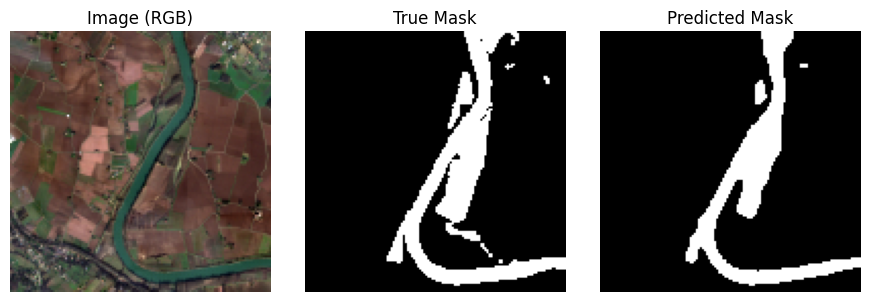

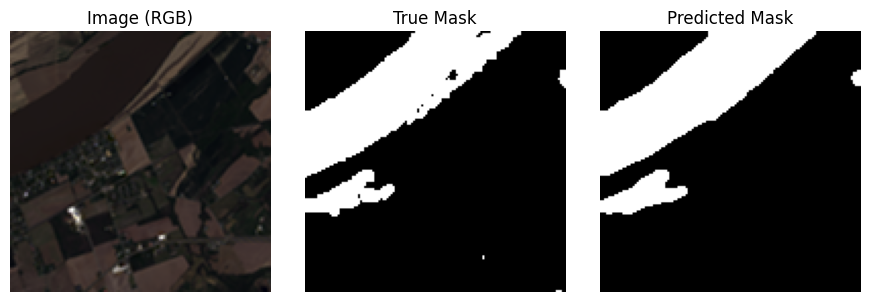

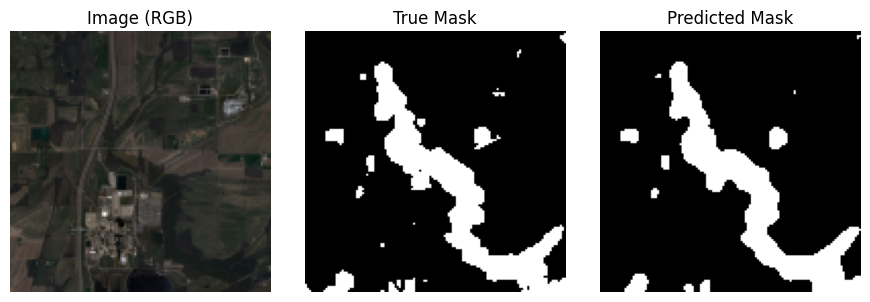

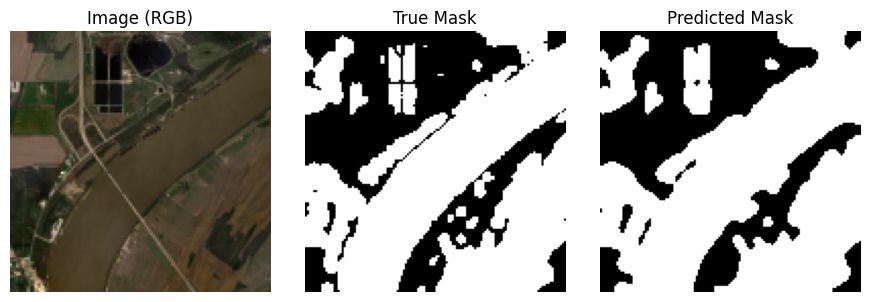

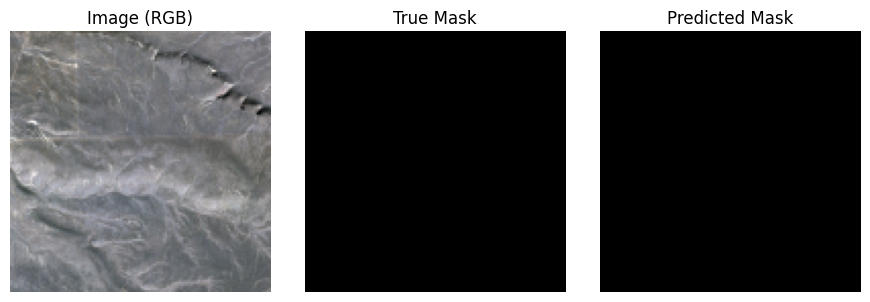

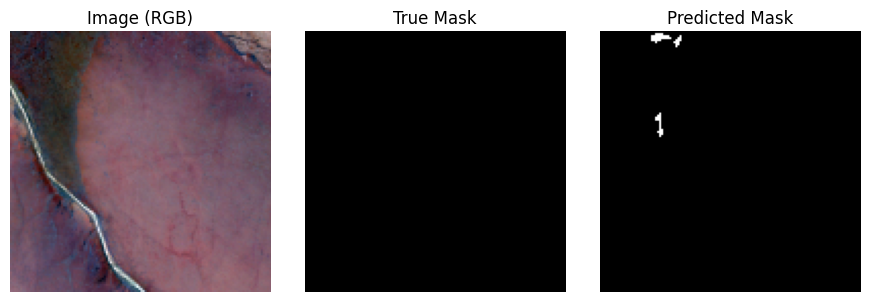

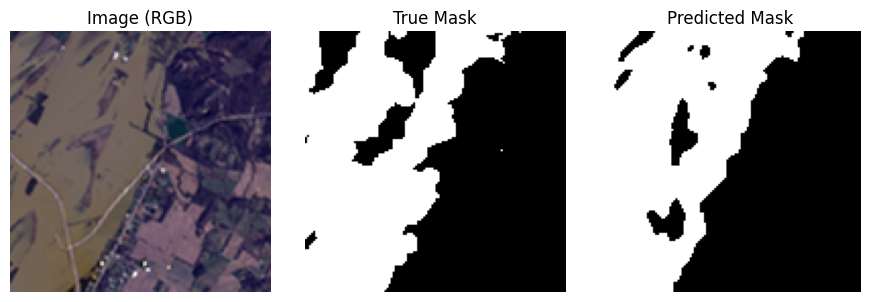

In [30]:
base_model.eval()
with torch.no_grad():
    for images, masks in val_loader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = base_model(images)
        preds = torch.sigmoid(outputs)
        preds = (preds > 0.5).float()

        for i in range(7):  # Show first 4 samples
            # Extract RGB bands (3,2,1) and normalize
            rgb = images[i][[3, 2, 1]].cpu().permute(1, 2, 0).numpy()
            rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min() + 1e-6)  # Normalize to [0,1]

            true_mask = masks[i][0].cpu().numpy()
            pred_mask = preds[i][0].cpu().numpy()

            plt.figure(figsize=(9,3))
            plt.subplot(1,3,1); plt.title("Image (RGB)"); plt.imshow(rgb); plt.axis("off")
            plt.subplot(1,3,2); plt.title("True Mask"); plt.imshow(true_mask, cmap='gray'); plt.axis("off")
            plt.subplot(1,3,3); plt.title("Predicted Mask"); plt.imshow(pred_mask, cmap='gray'); plt.axis("off")
            plt.tight_layout()
            plt.show()
        break


### 🧪 Evaluation Metrics Function

This section defines and runs evaluation logic for the trained model.

- `compute_metrics`:  
  Calculates standard segmentation metrics — Accuracy, Precision, Recall, F1 Score, and IoU — from predicted and ground truth masks using a configurable threshold (default: 0.5).

- `evaluate_metrics`:  
  Loops over the validation dataloader to:
  - Collect predictions from the model
  - Compute metrics batch-wise using `compute_metrics`
  - Aggregate and print the average results across the entire dataset.

➡️ Final output displays **mean Accuracy, Precision, Recall, F1-Score, and IoU** for validation performance.


In [31]:
def compute_metrics(preds, targets, threshold=0.5):
    preds = torch.sigmoid(preds)
    preds = (preds > threshold).float()

    preds = preds.cpu().numpy().astype(int)
    targets = targets.cpu().numpy().astype(int)

    TP = (preds * targets).sum()
    TN = ((1 - preds) * (1 - targets)).sum()
    FP = (preds * (1 - targets)).sum()
    FN = ((1 - preds) * targets).sum()

    epsilon = 1e-7

    accuracy = (TP + TN) / (TP + TN + FP + FN + epsilon)
    precision = TP / (TP + FP + epsilon)
    recall = TP / (TP + FN + epsilon)
    f1 = 2 * (precision * recall) / (precision + recall + epsilon)
    iou = TP / (TP + FP + FN + epsilon)

    return accuracy, precision, recall, f1, iou

def evaluate_metrics(model, dataloader, device):
    model.eval()
    total_acc, total_prec, total_rec, total_f1, total_iou = 0, 0, 0, 0, 0
    n_batches = 0

    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            acc, prec, rec, f1, iou = compute_metrics(outputs, masks)

            total_acc += acc
            total_prec += prec
            total_rec += rec
            total_f1 += f1
            total_iou += iou
            n_batches += 1

    print("=== Evaluation Metrics ===")
    print(f"Accuracy : {total_acc / n_batches:.4f}")
    print(f"Precision: {total_prec / n_batches:.4f}")
    print(f"Recall   : {total_rec / n_batches:.4f}")
    print(f"F1-Score : {total_f1 / n_batches:.4f}")
    print(f"IoU      : {total_iou / n_batches:.4f}")



evaluate_metrics(base_model, val_loader, device)


=== Evaluation Metrics ===
Accuracy : 0.9642
Precision: 0.9419
Recall   : 0.8932
F1-Score : 0.9167
IoU      : 0.8464


In [50]:
from rasterio.errors import NotGeoreferencedWarning
import warnings

# Suppress NotGeoreferencedWarning
warnings.filterwarnings("ignore", category=NotGeoreferencedWarning)

num_epochs =50
in_channels = 8

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_model3 = UNet(in_channels=in_channels, out_channels=1).to(device)
optimizer = torch.optim.Adam(base_model3.parameters(), lr=lr)
criterion = nn.BCEWithLogitsLoss()

mlflow.set_experiment("UNet_Baseline")           # Create or use experiment
if mlflow.active_run() is not None:
    mlflow.end_run()

# Start logging
with mlflow.start_run(run_name="Unet_Aug") as run:

    # Log the model
    #mlflow.pytorch.log_model(base_model3, "model")

    # Save model architecture to text
    with open("model_architecture.txt", "w") as f:
        f.write(str(base_model3))

    # Log architecture file as artifact
    #mlflow.log_artifact("model_architecture.txt")


    # Log parameters
    mlflow.log_param("model", "UNet")
    mlflow.log_param("in_channels", in_channels)
    mlflow.log_param("out_channels", 1)
    mlflow.log_param("epochs", num_epochs)
    mlflow.log_param("learning_rate", 1e-4)
    mlflow.log_param("loss_function", "BCEWithLogitsLoss")
    mlflow.log_param("NOrm", "Min_Max")
    mlflow.log_param("Bands" , "[5, 6, 12, 7, 9, 10, 11, 8]")
    mlflow.log_param("encoder_weights", "None")
    mlflow.log_param("batch_size", batch_size)
    #mlflow.log_param("augmentation", "None")

    mlflow.log_param("train_augmentation",
        "Albumentations: Resize(128x128), HorizontalFlip(0.3), VerticalFlip(0.3), RandomRotate90(0.3), "
        "ShiftScaleRotate(0.3), RandomBrightnessContrast(0.3), RandomGamma(0.3), "
        "GaussianBlur(0.2), GaussNoise(0.2), CoarseDropout(0.2)"
    )


    train_losses = []
    val_losses = []
    val_ious = []
    val_f1s = []

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        train_loss = train_one_epoch(base_model3, train_loader_aug, optimizer, criterion, device)
        val_loss, val_iou, val_acc, val_f1 = evaluate(base_model3, val_loader_aug, criterion, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_ious.append(val_iou)
        val_f1s.append(val_f1)

        # Log metrics
        mlflow.log_metric("train_loss", train_loss, step=epoch)
        mlflow.log_metric("val_loss", val_loss, step=epoch)
        mlflow.log_metric("val_iou", val_iou, step=epoch)
        mlflow.log_metric("val_f1", val_f1, step=epoch)

        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | IoU: {val_iou:.4f} | F1: {val_f1:.4f}")

    # Log final model
    mlflow.pytorch.log_model(base_model3, "model")






Epoch 1/50


100%|██████████| 8/8 [00:05<00:00,  1.40it/s]


Train Loss: 0.6136 | Val Loss: 0.7242 | IoU: 0.2260 | F1: 0.3659

Epoch 2/50


100%|██████████| 8/8 [00:04<00:00,  1.64it/s]


Train Loss: 0.4774 | Val Loss: 0.6301 | IoU: 0.5686 | F1: 0.7212

Epoch 3/50


100%|██████████| 8/8 [00:05<00:00,  1.57it/s]


Train Loss: 0.4264 | Val Loss: 0.4812 | IoU: 0.6158 | F1: 0.7583

Epoch 4/50


100%|██████████| 8/8 [00:04<00:00,  1.64it/s]


Train Loss: 0.3957 | Val Loss: 0.3807 | IoU: 0.6247 | F1: 0.7650

Epoch 5/50


100%|██████████| 8/8 [00:04<00:00,  1.72it/s]


Train Loss: 0.3851 | Val Loss: 0.3031 | IoU: 0.6447 | F1: 0.7810

Epoch 6/50


100%|██████████| 8/8 [00:04<00:00,  1.61it/s]


Train Loss: 0.3779 | Val Loss: 0.3607 | IoU: 0.6332 | F1: 0.7730

Epoch 7/50


100%|██████████| 8/8 [00:04<00:00,  1.69it/s]


Train Loss: 0.3788 | Val Loss: 0.3331 | IoU: 0.6350 | F1: 0.7750

Epoch 8/50


100%|██████████| 8/8 [00:10<00:00,  1.29s/it]


Train Loss: 0.3524 | Val Loss: 0.3324 | IoU: 0.6457 | F1: 0.7830

Epoch 9/50


100%|██████████| 8/8 [00:07<00:00,  1.04it/s]


Train Loss: 0.3530 | Val Loss: 0.3109 | IoU: 0.6626 | F1: 0.7953

Epoch 10/50


100%|██████████| 8/8 [00:05<00:00,  1.54it/s]


Train Loss: 0.3482 | Val Loss: 0.3053 | IoU: 0.6681 | F1: 0.7996

Epoch 11/50


100%|██████████| 8/8 [00:05<00:00,  1.57it/s]


Train Loss: 0.3489 | Val Loss: 0.2932 | IoU: 0.6653 | F1: 0.7977

Epoch 12/50


100%|██████████| 8/8 [00:04<00:00,  1.70it/s]


Train Loss: 0.3424 | Val Loss: 0.3076 | IoU: 0.6743 | F1: 0.8047

Epoch 13/50


100%|██████████| 8/8 [00:09<00:00,  1.16s/it]


Train Loss: 0.3384 | Val Loss: 0.2919 | IoU: 0.6594 | F1: 0.7933

Epoch 14/50


100%|██████████| 8/8 [00:04<00:00,  1.75it/s]


Train Loss: 0.3301 | Val Loss: 0.3121 | IoU: 0.6693 | F1: 0.8010

Epoch 15/50


100%|██████████| 8/8 [00:07<00:00,  1.04it/s]


Train Loss: 0.3296 | Val Loss: 0.2923 | IoU: 0.6689 | F1: 0.8006

Epoch 16/50


100%|██████████| 8/8 [00:04<00:00,  1.68it/s]


Train Loss: 0.3208 | Val Loss: 0.2710 | IoU: 0.6725 | F1: 0.8027

Epoch 17/50


100%|██████████| 8/8 [00:06<00:00,  1.33it/s]


Train Loss: 0.3213 | Val Loss: 0.2655 | IoU: 0.6679 | F1: 0.7989

Epoch 18/50


100%|██████████| 8/8 [00:04<00:00,  1.70it/s]


Train Loss: 0.3182 | Val Loss: 0.2821 | IoU: 0.6711 | F1: 0.8013

Epoch 19/50


100%|██████████| 8/8 [00:06<00:00,  1.24it/s]


Train Loss: 0.3209 | Val Loss: 0.2749 | IoU: 0.6650 | F1: 0.7971

Epoch 20/50


100%|██████████| 8/8 [00:04<00:00,  1.73it/s]


Train Loss: 0.3231 | Val Loss: 0.2790 | IoU: 0.6806 | F1: 0.8089

Epoch 21/50


100%|██████████| 8/8 [00:05<00:00,  1.53it/s]


Train Loss: 0.3149 | Val Loss: 0.2718 | IoU: 0.6600 | F1: 0.7942

Epoch 22/50


100%|██████████| 8/8 [00:04<00:00,  1.69it/s]


Train Loss: 0.3178 | Val Loss: 0.2446 | IoU: 0.6778 | F1: 0.8068

Epoch 23/50


100%|██████████| 8/8 [00:04<00:00,  1.66it/s]


Train Loss: 0.3072 | Val Loss: 0.2745 | IoU: 0.6732 | F1: 0.8036

Epoch 24/50


100%|██████████| 8/8 [00:04<00:00,  1.63it/s]


Train Loss: 0.3111 | Val Loss: 0.2745 | IoU: 0.6710 | F1: 0.8017

Epoch 25/50


100%|██████████| 8/8 [00:04<00:00,  1.73it/s]


Train Loss: 0.3065 | Val Loss: 0.2737 | IoU: 0.6695 | F1: 0.8007

Epoch 26/50


100%|██████████| 8/8 [00:05<00:00,  1.59it/s]


Train Loss: 0.3080 | Val Loss: 0.2472 | IoU: 0.6714 | F1: 0.8017

Epoch 27/50


100%|██████████| 8/8 [00:04<00:00,  1.69it/s]


Train Loss: 0.3016 | Val Loss: 0.2526 | IoU: 0.6596 | F1: 0.7927

Epoch 28/50


100%|██████████| 8/8 [00:05<00:00,  1.59it/s]


Train Loss: 0.2900 | Val Loss: 0.2472 | IoU: 0.6792 | F1: 0.8075

Epoch 29/50


100%|██████████| 8/8 [00:04<00:00,  1.69it/s]


Train Loss: 0.2968 | Val Loss: 0.2443 | IoU: 0.6436 | F1: 0.7809

Epoch 30/50


100%|██████████| 8/8 [00:05<00:00,  1.46it/s]


Train Loss: 0.2986 | Val Loss: 0.2488 | IoU: 0.6561 | F1: 0.7899

Epoch 31/50


100%|██████████| 8/8 [00:04<00:00,  1.72it/s]


Train Loss: 0.3029 | Val Loss: 0.2568 | IoU: 0.6893 | F1: 0.8157

Epoch 32/50


100%|██████████| 8/8 [00:06<00:00,  1.25it/s]


Train Loss: 0.2899 | Val Loss: 0.2571 | IoU: 0.6793 | F1: 0.8083

Epoch 33/50


100%|██████████| 8/8 [00:04<00:00,  1.67it/s]


Train Loss: 0.2817 | Val Loss: 0.2341 | IoU: 0.6783 | F1: 0.8066

Epoch 34/50


100%|██████████| 8/8 [00:06<00:00,  1.29it/s]


Train Loss: 0.2807 | Val Loss: 0.2413 | IoU: 0.6810 | F1: 0.8087

Epoch 35/50


100%|██████████| 8/8 [00:04<00:00,  1.75it/s]


Train Loss: 0.2794 | Val Loss: 0.2360 | IoU: 0.6899 | F1: 0.8154

Epoch 36/50


100%|██████████| 8/8 [00:06<00:00,  1.25it/s]


Train Loss: 0.2839 | Val Loss: 0.2273 | IoU: 0.6910 | F1: 0.8164

Epoch 37/50


100%|██████████| 8/8 [00:04<00:00,  1.70it/s]


Train Loss: 0.2803 | Val Loss: 0.2296 | IoU: 0.6811 | F1: 0.8087

Epoch 38/50


100%|██████████| 8/8 [00:06<00:00,  1.31it/s]


Train Loss: 0.2685 | Val Loss: 0.2258 | IoU: 0.6782 | F1: 0.8067

Epoch 39/50


100%|██████████| 8/8 [00:04<00:00,  1.67it/s]


Train Loss: 0.2735 | Val Loss: 0.2238 | IoU: 0.6870 | F1: 0.8137

Epoch 40/50


100%|██████████| 8/8 [00:05<00:00,  1.43it/s]


Train Loss: 0.2759 | Val Loss: 0.2196 | IoU: 0.6769 | F1: 0.8064

Epoch 41/50


100%|██████████| 8/8 [00:04<00:00,  1.70it/s]


Train Loss: 0.2757 | Val Loss: 0.2244 | IoU: 0.6844 | F1: 0.8117

Epoch 42/50


100%|██████████| 8/8 [00:05<00:00,  1.43it/s]


Train Loss: 0.2637 | Val Loss: 0.2179 | IoU: 0.6978 | F1: 0.8214

Epoch 43/50


100%|██████████| 8/8 [00:04<00:00,  1.66it/s]


Train Loss: 0.2768 | Val Loss: 0.2365 | IoU: 0.7037 | F1: 0.8256

Epoch 44/50


100%|██████████| 8/8 [00:05<00:00,  1.52it/s]


Train Loss: 0.2643 | Val Loss: 0.2241 | IoU: 0.6943 | F1: 0.8187

Epoch 45/50


100%|██████████| 8/8 [00:04<00:00,  1.67it/s]


Train Loss: 0.2671 | Val Loss: 0.2202 | IoU: 0.6637 | F1: 0.7955

Epoch 46/50


100%|██████████| 8/8 [00:05<00:00,  1.51it/s]


Train Loss: 0.2600 | Val Loss: 0.2184 | IoU: 0.6689 | F1: 0.8002

Epoch 47/50


100%|██████████| 8/8 [00:04<00:00,  1.63it/s]


Train Loss: 0.2625 | Val Loss: 0.2140 | IoU: 0.6861 | F1: 0.8124

Epoch 48/50


100%|██████████| 8/8 [00:04<00:00,  1.73it/s]


Train Loss: 0.2540 | Val Loss: 0.2213 | IoU: 0.6919 | F1: 0.8170

Epoch 49/50


100%|██████████| 8/8 [00:04<00:00,  1.66it/s]


Train Loss: 0.2554 | Val Loss: 0.2206 | IoU: 0.6866 | F1: 0.8134

Epoch 50/50


100%|██████████| 8/8 [00:04<00:00,  1.68it/s]
2025/08/01 19:03:46 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Train Loss: 0.2587 | Val Loss: 0.2085 | IoU: 0.6765 | F1: 0.8051


2025/08/01 19:03:47 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/08/01 19:03:51 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/08/01 19:03:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [51]:
    model_path = "/content/drive/MyDrive/Water Segmentation/models/unet_model_8bands_AUG.pth"
    torch.save(base_model3.state_dict(), model_path)
    mlflow.log_artifact(model_path)
    print("Model saved and logged to MLflow.")

Model saved and logged to MLflow.


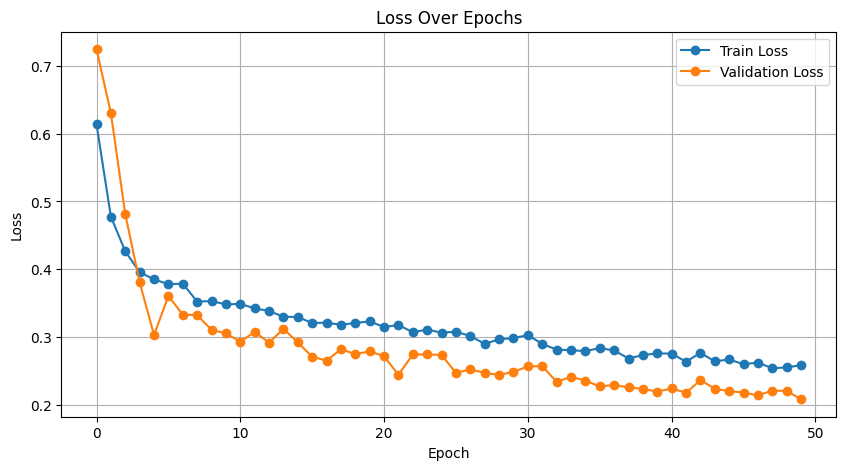

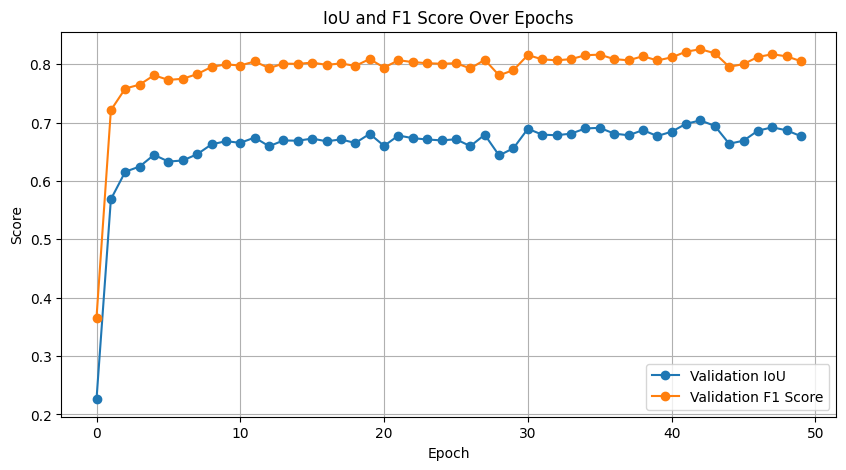

In [52]:
# Loss Chart
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# IoU & F1 Chart
plt.figure(figsize=(10, 5))
plt.plot(val_ious, label='Validation IoU', marker='o')
plt.plot(val_f1s, label='Validation F1 Score', marker='o')
plt.title("IoU and F1 Score Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()

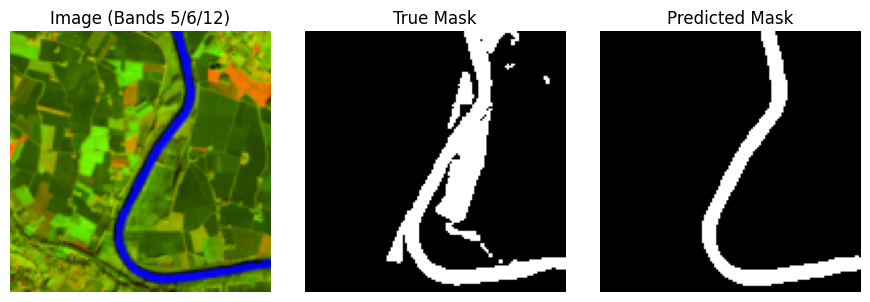

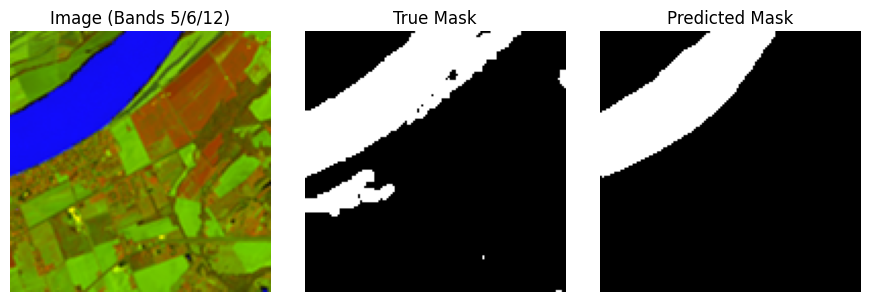

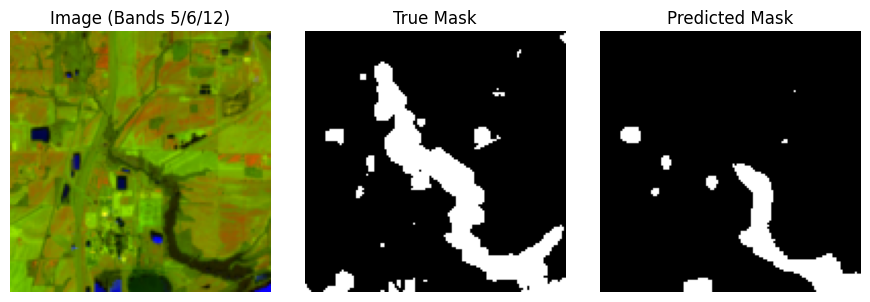

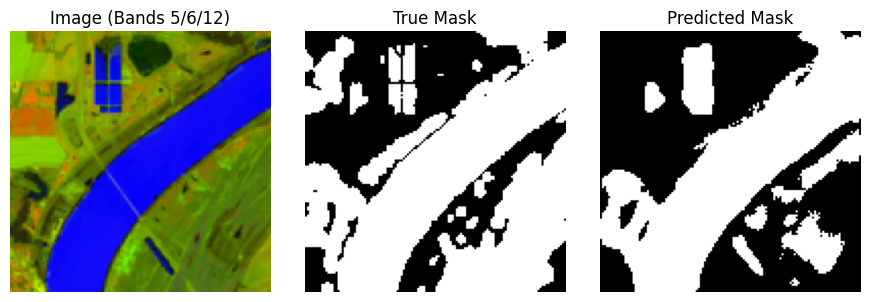

In [53]:
base_model3.eval()
with torch.no_grad():
    for images, masks in val_loader_aug:
        images = images.to(device)
        masks = masks.to(device)

        outputs = base_model3(images)
        preds = torch.sigmoid(outputs)
        preds = (preds > 0.5).float()

        for i in range(4):  # Show first 4 samples
            # Bands used: [5, 6, 12] → Channels 0, 1, 2
            rgb = images[i][[0, 1, 2]].cpu().permute(1, 2, 0).numpy()
            rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min() + 1e-6)  # Normalize to [0, 1]

            true_mask = masks[i][0].cpu().numpy()
            pred_mask = preds[i][0].cpu().numpy()

            plt.figure(figsize=(9, 3))
            plt.subplot(1, 3, 1)
            plt.title("Image (Bands 5/6/12)")
            plt.imshow(rgb)
            plt.axis("off")

            plt.subplot(1, 3, 2)
            plt.title("True Mask")
            plt.imshow(true_mask, cmap='gray')
            plt.axis("off")

            plt.subplot(1, 3, 3)
            plt.title("Predicted Mask")
            plt.imshow(pred_mask, cmap='gray')
            plt.axis("off")

            plt.tight_layout()
            plt.show()
        break


In [54]:
def compute_metrics(preds, targets, threshold=0.5):
    preds = torch.sigmoid(preds)
    preds = (preds > threshold).float()

    preds = preds.cpu().numpy().astype(int)
    targets = targets.cpu().numpy().astype(int)

    TP = (preds * targets).sum()
    TN = ((1 - preds) * (1 - targets)).sum()
    FP = (preds * (1 - targets)).sum()
    FN = ((1 - preds) * targets).sum()

    epsilon = 1e-7

    accuracy = (TP + TN) / (TP + TN + FP + FN + epsilon)
    precision = TP / (TP + FP + epsilon)
    recall = TP / (TP + FN + epsilon)
    f1 = 2 * (precision * recall) / (precision + recall + epsilon)
    iou = TP / (TP + FP + FN + epsilon)

    return accuracy, precision, recall, f1, iou

def evaluate_metrics(model, dataloader, device):
    model.eval()
    total_acc, total_prec, total_rec, total_f1, total_iou = 0, 0, 0, 0, 0
    n_batches = 0

    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            acc, prec, rec, f1, iou = compute_metrics(outputs, masks)

            total_acc += acc
            total_prec += prec
            total_rec += rec
            total_f1 += f1
            total_iou += iou
            n_batches += 1

    print("=== Evaluation Metrics ===")
    print(f"Accuracy : {total_acc / n_batches:.4f}")
    print(f"Precision: {total_prec / n_batches:.4f}")
    print(f"Recall   : {total_rec / n_batches:.4f}")
    print(f"F1-Score : {total_f1 / n_batches:.4f}")
    print(f"IoU      : {total_iou / n_batches:.4f}")



evaluate_metrics(base_model3, val_loader_aug, device)


=== Evaluation Metrics ===
Accuracy : 0.9260
Precision: 0.9189
Recall   : 0.7180
F1-Score : 0.8051
IoU      : 0.6765


In [55]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
in_channels =12
# ✅ Define the model using SMP with 12 input channels
model_DLV3 = smp.DeepLabV3(
    encoder_name="resnet34",        # Backbone
    encoder_weights="imagenet",     # Pretrained on ImageNet
    in_channels=in_channels,                 # Your input channel count (e.g., 12 bands)
    classes=1                       # Output classes (binary segmentation)
)

model_DLV3.to(device)  # Send to GPU if available

# ✅ Define optimizer and loss
optimizer = optim.Adam(model_DLV3.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()

# End any previously active run
if mlflow.active_run():
    mlflow.end_run()

# 🚀 Start MLflow run
with mlflow.start_run(run_name="DeepLabV3"):

    # 🧩 Log experiment parameters
    mlflow.log_param("model", "DeepLabV3_ResNet34")
    mlflow.log_param("in_channels", in_channels)
    mlflow.log_param("out_channels", 1)
    mlflow.log_param("epochs", num_epochs)
    mlflow.log_param("learning_rate", lr)
    mlflow.log_param("NOrm", "Min_Max")
    mlflow.log_param("Bands" , "All")
    mlflow.log_param("loss_function", "BCEWithLogitsLoss")
    mlflow.log_param("optimizer", "Adam")
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("encoder_weights", "imagenet")
    mlflow.log_param("augmentation", "None")

    # 📊 Metric containers
    train_losses, val_losses, val_ious, val_f1s = [], [], [], []

    # 🔁 Training loop
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        # 🎯 Train
        train_loss = train_one_epoch(model_DLV3, train_loader, optimizer, criterion, device)

        # 🧪 Validate
        val_loss, val_iou, val_acc, val_f1 = evaluate(model_DLV3, val_loader, criterion, device)

        # 📉 Log to MLflow
        mlflow.log_metric("train_loss", train_loss, step=epoch)
        mlflow.log_metric("val_loss", val_loss, step=epoch)
        mlflow.log_metric("val_iou", val_iou, step=epoch)
        mlflow.log_metric("val_f1", val_f1, step=epoch)

        # 📥 Append metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_ious.append(val_iou)
        val_f1s.append(val_f1)

        # 🖨️ Print
        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | IoU: {val_iou:.4f} | F1: {val_f1:.4f}")

    # 💾 Log the model to MLflow
    mlflow.pytorch.log_model(model_DLV3, "model")



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]


Epoch 1/50


100%|██████████| 8/8 [00:07<00:00,  1.12it/s]


Train Loss: 0.6118 | Val Loss: 0.5989 | IoU: 0.5031 | F1: 0.6673

Epoch 2/50


100%|██████████| 8/8 [00:06<00:00,  1.32it/s]


Train Loss: 0.4277 | Val Loss: 0.4563 | IoU: 0.5670 | F1: 0.7232

Epoch 3/50


100%|██████████| 8/8 [00:06<00:00,  1.29it/s]


Train Loss: 0.3414 | Val Loss: 0.3400 | IoU: 0.5951 | F1: 0.7460

Epoch 4/50


100%|██████████| 8/8 [00:06<00:00,  1.16it/s]


Train Loss: 0.3030 | Val Loss: 0.2893 | IoU: 0.6267 | F1: 0.7699

Epoch 5/50


100%|██████████| 8/8 [00:06<00:00,  1.30it/s]


Train Loss: 0.2734 | Val Loss: 0.2508 | IoU: 0.6494 | F1: 0.7866

Epoch 6/50


100%|██████████| 8/8 [00:09<00:00,  1.19s/it]


Train Loss: 0.2720 | Val Loss: 0.2382 | IoU: 0.6575 | F1: 0.7921

Epoch 7/50


100%|██████████| 8/8 [00:06<00:00,  1.18it/s]


Train Loss: 0.2578 | Val Loss: 0.2357 | IoU: 0.6557 | F1: 0.7911

Epoch 8/50


100%|██████████| 8/8 [00:06<00:00,  1.33it/s]


Train Loss: 0.2429 | Val Loss: 0.2227 | IoU: 0.6685 | F1: 0.8008

Epoch 9/50


100%|██████████| 8/8 [00:06<00:00,  1.22it/s]


Train Loss: 0.2331 | Val Loss: 0.2139 | IoU: 0.6758 | F1: 0.8059

Epoch 10/50


100%|██████████| 8/8 [00:07<00:00,  1.12it/s]


Train Loss: 0.2166 | Val Loss: 0.2124 | IoU: 0.6639 | F1: 0.7975

Epoch 11/50


100%|██████████| 8/8 [00:06<00:00,  1.25it/s]


Train Loss: 0.2127 | Val Loss: 0.2056 | IoU: 0.6925 | F1: 0.8177

Epoch 12/50


100%|██████████| 8/8 [00:06<00:00,  1.21it/s]


Train Loss: 0.2055 | Val Loss: 0.1958 | IoU: 0.6920 | F1: 0.8175

Epoch 13/50


100%|██████████| 8/8 [00:06<00:00,  1.25it/s]


Train Loss: 0.1996 | Val Loss: 0.1959 | IoU: 0.6918 | F1: 0.8172

Epoch 14/50


100%|██████████| 8/8 [00:07<00:00,  1.04it/s]


Train Loss: 0.2056 | Val Loss: 0.1978 | IoU: 0.6826 | F1: 0.8111

Epoch 15/50


100%|██████████| 8/8 [00:07<00:00,  1.03it/s]


Train Loss: 0.1922 | Val Loss: 0.1966 | IoU: 0.6992 | F1: 0.8229

Epoch 16/50


100%|██████████| 8/8 [00:06<00:00,  1.25it/s]


Train Loss: 0.1868 | Val Loss: 0.1889 | IoU: 0.6974 | F1: 0.8212

Epoch 17/50


100%|██████████| 8/8 [00:06<00:00,  1.22it/s]


Train Loss: 0.1855 | Val Loss: 0.1824 | IoU: 0.7175 | F1: 0.8355

Epoch 18/50


100%|██████████| 8/8 [00:06<00:00,  1.16it/s]


Train Loss: 0.1874 | Val Loss: 0.1764 | IoU: 0.7131 | F1: 0.8322

Epoch 19/50


100%|██████████| 8/8 [00:06<00:00,  1.31it/s]


Train Loss: 0.1741 | Val Loss: 0.1783 | IoU: 0.7174 | F1: 0.8354

Epoch 20/50


100%|██████████| 8/8 [00:06<00:00,  1.22it/s]


Train Loss: 0.1787 | Val Loss: 0.1816 | IoU: 0.7147 | F1: 0.8333

Epoch 21/50


100%|██████████| 8/8 [00:06<00:00,  1.31it/s]


Train Loss: 0.1700 | Val Loss: 0.1742 | IoU: 0.7217 | F1: 0.8382

Epoch 22/50


100%|██████████| 8/8 [00:06<00:00,  1.30it/s]


Train Loss: 0.1666 | Val Loss: 0.1772 | IoU: 0.7320 | F1: 0.8451

Epoch 23/50


100%|██████████| 8/8 [00:06<00:00,  1.20it/s]


Train Loss: 0.1631 | Val Loss: 0.1673 | IoU: 0.7436 | F1: 0.8529

Epoch 24/50


100%|██████████| 8/8 [00:06<00:00,  1.33it/s]


Train Loss: 0.1590 | Val Loss: 0.1719 | IoU: 0.7223 | F1: 0.8386

Epoch 25/50


100%|██████████| 8/8 [00:06<00:00,  1.20it/s]


Train Loss: 0.1600 | Val Loss: 0.1708 | IoU: 0.7391 | F1: 0.8499

Epoch 26/50


100%|██████████| 8/8 [00:06<00:00,  1.30it/s]


Train Loss: 0.1568 | Val Loss: 0.1689 | IoU: 0.7396 | F1: 0.8503

Epoch 27/50


100%|██████████| 8/8 [00:06<00:00,  1.28it/s]


Train Loss: 0.1527 | Val Loss: 0.1635 | IoU: 0.7443 | F1: 0.8534

Epoch 28/50


100%|██████████| 8/8 [00:06<00:00,  1.22it/s]


Train Loss: 0.1466 | Val Loss: 0.1662 | IoU: 0.7224 | F1: 0.8387

Epoch 29/50


100%|██████████| 8/8 [00:06<00:00,  1.19it/s]


Train Loss: 0.1426 | Val Loss: 0.1611 | IoU: 0.7474 | F1: 0.8554

Epoch 30/50


100%|██████████| 8/8 [00:06<00:00,  1.25it/s]


Train Loss: 0.1424 | Val Loss: 0.1640 | IoU: 0.7532 | F1: 0.8592

Epoch 31/50


100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


Train Loss: 0.1377 | Val Loss: 0.1579 | IoU: 0.7474 | F1: 0.8554

Epoch 32/50


100%|██████████| 8/8 [00:06<00:00,  1.24it/s]


Train Loss: 0.1377 | Val Loss: 0.1564 | IoU: 0.7606 | F1: 0.8640

Epoch 33/50


100%|██████████| 8/8 [00:06<00:00,  1.28it/s]


Train Loss: 0.1379 | Val Loss: 0.1552 | IoU: 0.7539 | F1: 0.8597

Epoch 34/50


100%|██████████| 8/8 [00:06<00:00,  1.31it/s]


Train Loss: 0.1344 | Val Loss: 0.1555 | IoU: 0.7608 | F1: 0.8641

Epoch 35/50


100%|██████████| 8/8 [00:06<00:00,  1.32it/s]


Train Loss: 0.1324 | Val Loss: 0.1528 | IoU: 0.7597 | F1: 0.8634

Epoch 36/50


100%|██████████| 8/8 [00:06<00:00,  1.20it/s]


Train Loss: 0.1304 | Val Loss: 0.1540 | IoU: 0.7577 | F1: 0.8622

Epoch 37/50


100%|██████████| 8/8 [00:05<00:00,  1.34it/s]


Train Loss: 0.1279 | Val Loss: 0.1541 | IoU: 0.7688 | F1: 0.8693

Epoch 38/50


100%|██████████| 8/8 [00:06<00:00,  1.27it/s]


Train Loss: 0.1231 | Val Loss: 0.1548 | IoU: 0.7585 | F1: 0.8627

Epoch 39/50


100%|██████████| 8/8 [00:06<00:00,  1.29it/s]


Train Loss: 0.1274 | Val Loss: 0.1499 | IoU: 0.7634 | F1: 0.8659

Epoch 40/50


100%|██████████| 8/8 [00:05<00:00,  1.33it/s]


Train Loss: 0.1207 | Val Loss: 0.1518 | IoU: 0.7725 | F1: 0.8716

Epoch 41/50


100%|██████████| 8/8 [00:06<00:00,  1.24it/s]


Train Loss: 0.1175 | Val Loss: 0.1488 | IoU: 0.7668 | F1: 0.8680

Epoch 42/50


100%|██████████| 8/8 [00:06<00:00,  1.23it/s]


Train Loss: 0.1149 | Val Loss: 0.1469 | IoU: 0.7817 | F1: 0.8775

Epoch 43/50


100%|██████████| 8/8 [00:06<00:00,  1.25it/s]


Train Loss: 0.1132 | Val Loss: 0.1459 | IoU: 0.7739 | F1: 0.8726

Epoch 44/50


100%|██████████| 8/8 [00:06<00:00,  1.18it/s]


Train Loss: 0.1130 | Val Loss: 0.1474 | IoU: 0.7770 | F1: 0.8745

Epoch 45/50


100%|██████████| 8/8 [00:06<00:00,  1.32it/s]


Train Loss: 0.1122 | Val Loss: 0.1466 | IoU: 0.7819 | F1: 0.8776

Epoch 46/50


100%|██████████| 8/8 [00:06<00:00,  1.20it/s]


Train Loss: 0.1082 | Val Loss: 0.1475 | IoU: 0.7688 | F1: 0.8693

Epoch 47/50


100%|██████████| 8/8 [00:06<00:00,  1.33it/s]


Train Loss: 0.1078 | Val Loss: 0.1443 | IoU: 0.7840 | F1: 0.8790

Epoch 48/50


100%|██████████| 8/8 [00:06<00:00,  1.28it/s]


Train Loss: 0.1037 | Val Loss: 0.1451 | IoU: 0.7760 | F1: 0.8739

Epoch 49/50


100%|██████████| 8/8 [00:06<00:00,  1.26it/s]


Train Loss: 0.1038 | Val Loss: 0.1432 | IoU: 0.7841 | F1: 0.8790

Epoch 50/50


100%|██████████| 8/8 [00:05<00:00,  1.34it/s]
2025/08/01 19:16:17 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Train Loss: 0.1028 | Val Loss: 0.1459 | IoU: 0.7755 | F1: 0.8735


2025/08/01 19:16:18 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/08/01 19:16:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [56]:
    # Save model to .pth file locally
    model_path = "/content/drive/MyDrive/Water Segmentation/models/DLab_model.pth"
    torch.save(model_DLV3.state_dict(),model_path)
    mlflow.log_artifact(model_path)
    print("Model saved and logged to MLflow.")



Model saved and logged to MLflow.


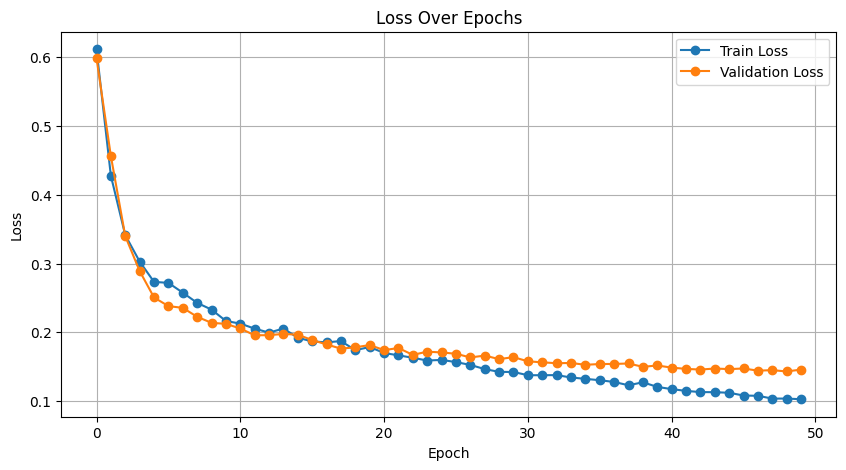

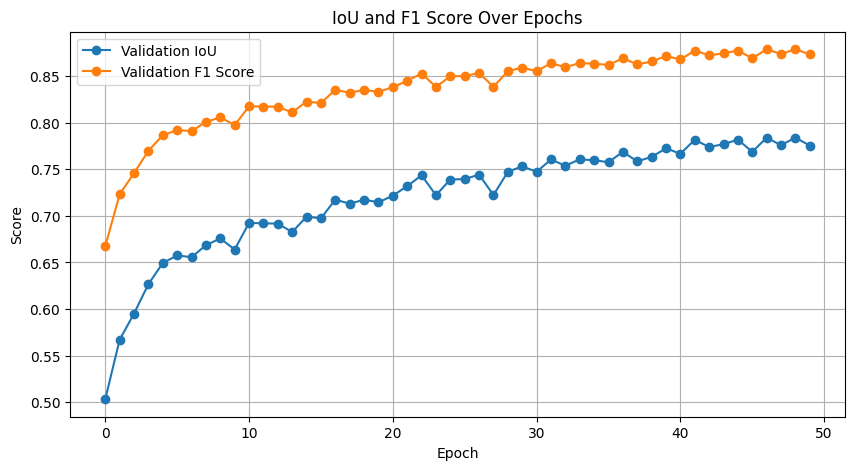

In [57]:
# Loss Chart
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# IoU & F1 Chart
plt.figure(figsize=(10, 5))
plt.plot(val_ious, label='Validation IoU', marker='o')
plt.plot(val_f1s, label='Validation F1 Score', marker='o')
plt.title("IoU and F1 Score Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()

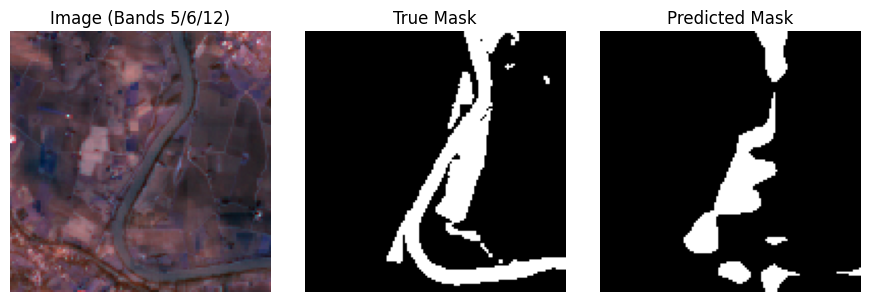

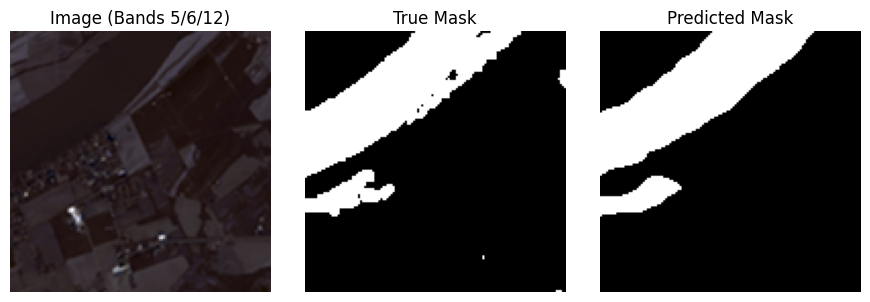

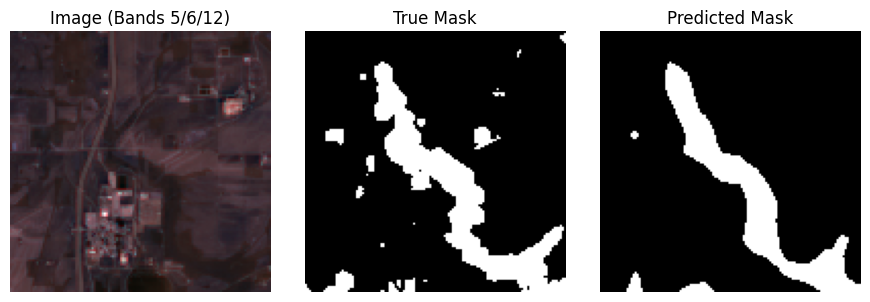

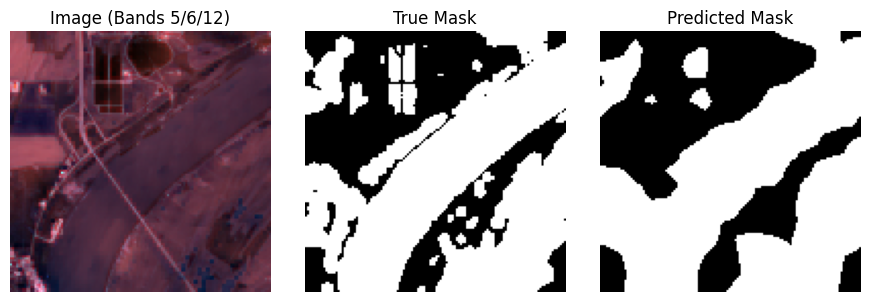

In [59]:
model_DLV3.eval()
with torch.no_grad():
    for images, masks in val_loader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model_DLV3(images)
        preds = torch.sigmoid(outputs)
        preds = (preds > 0.5).float()

        for i in range(4):  # Show first 4 samples
            # Bands used: [5, 6, 12] → Channels 0, 1, 2
            rgb = images[i][[0, 1, 2]].cpu().permute(1, 2, 0).numpy()
            rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min() + 1e-6)  # Normalize to [0, 1]

            true_mask = masks[i][0].cpu().numpy()
            pred_mask = preds[i][0].cpu().numpy()

            plt.figure(figsize=(9, 3))
            plt.subplot(1, 3, 1)
            plt.title("Image (Bands 5/6/12)")
            plt.imshow(rgb)
            plt.axis("off")

            plt.subplot(1, 3, 2)
            plt.title("True Mask")
            plt.imshow(true_mask, cmap='gray')
            plt.axis("off")

            plt.subplot(1, 3, 3)
            plt.title("Predicted Mask")
            plt.imshow(pred_mask, cmap='gray')
            plt.axis("off")

            plt.tight_layout()
            plt.show()
        break


In [60]:
def compute_metrics(preds, targets, threshold=0.5):
    preds = torch.sigmoid(preds)
    preds = (preds > threshold).float()

    preds = preds.cpu().numpy().astype(int)
    targets = targets.cpu().numpy().astype(int)

    TP = (preds * targets).sum()
    TN = ((1 - preds) * (1 - targets)).sum()
    FP = (preds * (1 - targets)).sum()
    FN = ((1 - preds) * targets).sum()

    epsilon = 1e-7

    accuracy = (TP + TN) / (TP + TN + FP + FN + epsilon)
    precision = TP / (TP + FP + epsilon)
    recall = TP / (TP + FN + epsilon)
    f1 = 2 * (precision * recall) / (precision + recall + epsilon)
    iou = TP / (TP + FP + FN + epsilon)

    return accuracy, precision, recall, f1, iou

def evaluate_metrics(model, dataloader, device):
    model.eval()
    total_acc, total_prec, total_rec, total_f1, total_iou = 0, 0, 0, 0, 0
    n_batches = 0

    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            acc, prec, rec, f1, iou = compute_metrics(outputs, masks)

            total_acc += acc
            total_prec += prec
            total_rec += rec
            total_f1 += f1
            total_iou += iou
            n_batches += 1

    print("=== Evaluation Metrics ===")
    print(f"Accuracy : {total_acc / n_batches:.4f}")
    print(f"Precision: {total_prec / n_batches:.4f}")
    print(f"Recall   : {total_rec / n_batches:.4f}")
    print(f"F1-Score : {total_f1 / n_batches:.4f}")
    print(f"IoU      : {total_iou / n_batches:.4f}")



evaluate_metrics(model_DLV3, val_loader, device)


=== Evaluation Metrics ===
Accuracy : 0.9455
Precision: 0.9228
Recall   : 0.8293
F1-Score : 0.8735
IoU      : 0.7755


In [66]:
in_channels =8

# ✅ Define the model using SMP with 12 input channels
model_DLV3 = smp.DeepLabV3(
    encoder_name="resnet34",        # Backbone
    encoder_weights="imagenet",     # Pretrained on ImageNet
    in_channels=in_channels,                 # Your input channel count (e.g., 12 bands)
    classes=1                       # Output classes (binary segmentation)
)

model_DLV3.to(device)  # Send to GPU if available

# ✅ Define optimizer and loss
optimizer = optim.Adam(model_DLV3.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()

# End any previously active run
if mlflow.active_run():
    mlflow.end_run()

# 🚀 Start MLflow run
with mlflow.start_run(run_name="DeepLabV3_Aug"):


    # 🧩 Log experiment parameters
    mlflow.log_param("model", "DeepLabV3_ResNet34")
    mlflow.log_param("in_channels", in_channels)
    mlflow.log_param("out_channels", 1)
    mlflow.log_param("epochs", num_epochs)
    mlflow.log_param("learning_rate", lr)
    mlflow.log_param("NOrm", "Min_Max")
    mlflow.log_param("Bands" , "[5, 6, 12, 7, 9, 10, 11, 8]")
    mlflow.log_param("loss_function", "BCEWithLogitsLoss")
    mlflow.log_param("optimizer", "Adam")
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("encoder_weights", "imagenet")
    mlflow.log_param("augmentation", "None")



    # 📊 Metric containers
    train_losses, val_losses, val_ious, val_f1s = [], [], [], []

    # 🔁 Training loop
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        # 🎯 Train
        train_loss = train_one_epoch(model_DLV3, train_loader_aug, optimizer, criterion, device)

        # 🧪 Validate
        val_loss, val_iou, val_acc, val_f1 = evaluate(model_DLV3, val_loader_aug, criterion, device)

        # 📉 Log to MLflow
        mlflow.log_metric("train_loss", train_loss, step=epoch)
        mlflow.log_metric("val_loss", val_loss, step=epoch)
        mlflow.log_metric("val_iou", val_iou, step=epoch)
        mlflow.log_metric("val_f1", val_f1, step=epoch)

        # 📥 Append metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_ious.append(val_iou)
        val_f1s.append(val_f1)

        # 🖨️ Print
        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | IoU: {val_iou:.4f} | F1: {val_f1:.4f}")

    # 💾 Log the model to MLflow
    mlflow.pytorch.log_model(model_DLV3, "model")





Epoch 1/50


100%|██████████| 8/8 [00:04<00:00,  1.96it/s]


Train Loss: 0.5406 | Val Loss: 0.6109 | IoU: 0.4800 | F1: 0.6478

Epoch 2/50


100%|██████████| 8/8 [00:07<00:00,  1.14it/s]


Train Loss: 0.3766 | Val Loss: 0.4450 | IoU: 0.5287 | F1: 0.6908

Epoch 3/50


100%|██████████| 8/8 [00:04<00:00,  1.92it/s]


Train Loss: 0.3416 | Val Loss: 0.3617 | IoU: 0.6036 | F1: 0.7519

Epoch 4/50


100%|██████████| 8/8 [00:05<00:00,  1.45it/s]


Train Loss: 0.2844 | Val Loss: 0.3034 | IoU: 0.5808 | F1: 0.7342

Epoch 5/50


100%|██████████| 8/8 [00:05<00:00,  1.59it/s]


Train Loss: 0.2678 | Val Loss: 0.2707 | IoU: 0.6333 | F1: 0.7746

Epoch 6/50


100%|██████████| 8/8 [00:05<00:00,  1.51it/s]


Train Loss: 0.2863 | Val Loss: 0.2572 | IoU: 0.6324 | F1: 0.7737

Epoch 7/50


100%|██████████| 8/8 [00:04<00:00,  1.94it/s]


Train Loss: 0.2558 | Val Loss: 0.2724 | IoU: 0.6410 | F1: 0.7802

Epoch 8/50


100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


Train Loss: 0.2382 | Val Loss: 0.2701 | IoU: 0.6551 | F1: 0.7908

Epoch 9/50


100%|██████████| 8/8 [00:04<00:00,  1.93it/s]


Train Loss: 0.2272 | Val Loss: 0.2270 | IoU: 0.6658 | F1: 0.7989

Epoch 10/50


100%|██████████| 8/8 [00:05<00:00,  1.60it/s]


Train Loss: 0.2210 | Val Loss: 0.2191 | IoU: 0.6860 | F1: 0.8131

Epoch 11/50


100%|██████████| 8/8 [00:04<00:00,  1.98it/s]


Train Loss: 0.2153 | Val Loss: 0.2073 | IoU: 0.6762 | F1: 0.8066

Epoch 12/50


100%|██████████| 8/8 [00:04<00:00,  1.87it/s]


Train Loss: 0.2047 | Val Loss: 0.2082 | IoU: 0.6811 | F1: 0.8097

Epoch 13/50


100%|██████████| 8/8 [00:04<00:00,  1.91it/s]


Train Loss: 0.1998 | Val Loss: 0.2011 | IoU: 0.6960 | F1: 0.8204

Epoch 14/50


100%|██████████| 8/8 [00:04<00:00,  1.93it/s]


Train Loss: 0.1916 | Val Loss: 0.1954 | IoU: 0.7032 | F1: 0.8255

Epoch 15/50


100%|██████████| 8/8 [00:04<00:00,  1.71it/s]


Train Loss: 0.1860 | Val Loss: 0.1952 | IoU: 0.6999 | F1: 0.8233

Epoch 16/50


100%|██████████| 8/8 [00:03<00:00,  2.00it/s]


Train Loss: 0.1802 | Val Loss: 0.1927 | IoU: 0.7065 | F1: 0.8276

Epoch 17/50


100%|██████████| 8/8 [00:04<00:00,  1.74it/s]


Train Loss: 0.1781 | Val Loss: 0.1878 | IoU: 0.7157 | F1: 0.8342

Epoch 18/50


100%|██████████| 8/8 [00:04<00:00,  1.91it/s]


Train Loss: 0.1708 | Val Loss: 0.1838 | IoU: 0.7009 | F1: 0.8238

Epoch 19/50


100%|██████████| 8/8 [00:04<00:00,  1.61it/s]


Train Loss: 0.1703 | Val Loss: 0.1851 | IoU: 0.7163 | F1: 0.8346

Epoch 20/50


100%|██████████| 8/8 [00:06<00:00,  1.25it/s]


Train Loss: 0.1689 | Val Loss: 0.1786 | IoU: 0.7077 | F1: 0.8288

Epoch 21/50


100%|██████████| 8/8 [00:04<00:00,  1.90it/s]


Train Loss: 0.1665 | Val Loss: 0.1772 | IoU: 0.7227 | F1: 0.8390

Epoch 22/50


100%|██████████| 8/8 [00:05<00:00,  1.47it/s]


Train Loss: 0.1646 | Val Loss: 0.1742 | IoU: 0.7166 | F1: 0.8348

Epoch 23/50


100%|██████████| 8/8 [00:06<00:00,  1.25it/s]


Train Loss: 0.1568 | Val Loss: 0.1747 | IoU: 0.7205 | F1: 0.8375

Epoch 24/50


100%|██████████| 8/8 [00:04<00:00,  1.69it/s]


Train Loss: 0.1518 | Val Loss: 0.1720 | IoU: 0.7279 | F1: 0.8424

Epoch 25/50


100%|██████████| 8/8 [00:04<00:00,  1.92it/s]


Train Loss: 0.1514 | Val Loss: 0.1706 | IoU: 0.7324 | F1: 0.8455

Epoch 26/50


100%|██████████| 8/8 [00:06<00:00,  1.33it/s]


Train Loss: 0.1495 | Val Loss: 0.1670 | IoU: 0.7370 | F1: 0.8485

Epoch 27/50


100%|██████████| 8/8 [00:04<00:00,  1.60it/s]


Train Loss: 0.1462 | Val Loss: 0.1684 | IoU: 0.7251 | F1: 0.8406

Epoch 28/50


100%|██████████| 8/8 [00:05<00:00,  1.52it/s]


Train Loss: 0.1423 | Val Loss: 0.1665 | IoU: 0.7330 | F1: 0.8459

Epoch 29/50


100%|██████████| 8/8 [00:05<00:00,  1.55it/s]


Train Loss: 0.1426 | Val Loss: 0.1638 | IoU: 0.7455 | F1: 0.8542

Epoch 30/50


100%|██████████| 8/8 [00:06<00:00,  1.20it/s]


Train Loss: 0.1410 | Val Loss: 0.1656 | IoU: 0.7308 | F1: 0.8444

Epoch 31/50


100%|██████████| 8/8 [00:04<00:00,  1.95it/s]


Train Loss: 0.1483 | Val Loss: 0.1692 | IoU: 0.7438 | F1: 0.8531

Epoch 32/50


100%|██████████| 8/8 [00:05<00:00,  1.50it/s]


Train Loss: 0.1421 | Val Loss: 0.1767 | IoU: 0.7337 | F1: 0.8464

Epoch 33/50


100%|██████████| 8/8 [00:04<00:00,  1.93it/s]


Train Loss: 0.1358 | Val Loss: 0.1625 | IoU: 0.7349 | F1: 0.8471

Epoch 34/50


100%|██████████| 8/8 [00:04<00:00,  1.75it/s]


Train Loss: 0.1330 | Val Loss: 0.1610 | IoU: 0.7382 | F1: 0.8494

Epoch 35/50


100%|██████████| 8/8 [00:03<00:00,  2.00it/s]


Train Loss: 0.1364 | Val Loss: 0.1609 | IoU: 0.7206 | F1: 0.8376

Epoch 36/50


100%|██████████| 8/8 [00:05<00:00,  1.49it/s]


Train Loss: 0.1273 | Val Loss: 0.1589 | IoU: 0.7447 | F1: 0.8536

Epoch 37/50


100%|██████████| 8/8 [00:04<00:00,  1.94it/s]


Train Loss: 0.1231 | Val Loss: 0.1578 | IoU: 0.7545 | F1: 0.8600

Epoch 38/50


100%|██████████| 8/8 [00:04<00:00,  1.98it/s]


Train Loss: 0.1206 | Val Loss: 0.1542 | IoU: 0.7609 | F1: 0.8642

Epoch 39/50


100%|██████████| 8/8 [00:04<00:00,  1.81it/s]


Train Loss: 0.1189 | Val Loss: 0.1570 | IoU: 0.7452 | F1: 0.8540

Epoch 40/50


100%|██████████| 8/8 [00:04<00:00,  1.92it/s]


Train Loss: 0.1168 | Val Loss: 0.1534 | IoU: 0.7587 | F1: 0.8628

Epoch 41/50


100%|██████████| 8/8 [00:05<00:00,  1.58it/s]


Train Loss: 0.1166 | Val Loss: 0.1523 | IoU: 0.7615 | F1: 0.8646

Epoch 42/50


100%|██████████| 8/8 [00:04<00:00,  1.92it/s]


Train Loss: 0.1116 | Val Loss: 0.1528 | IoU: 0.7624 | F1: 0.8652

Epoch 43/50


100%|██████████| 8/8 [00:05<00:00,  1.49it/s]


Train Loss: 0.1116 | Val Loss: 0.1498 | IoU: 0.7618 | F1: 0.8648

Epoch 44/50


100%|██████████| 8/8 [00:04<00:00,  1.97it/s]


Train Loss: 0.1102 | Val Loss: 0.1539 | IoU: 0.7635 | F1: 0.8659

Epoch 45/50


100%|██████████| 8/8 [00:05<00:00,  1.52it/s]


Train Loss: 0.1067 | Val Loss: 0.1530 | IoU: 0.7591 | F1: 0.8631

Epoch 46/50


100%|██████████| 8/8 [00:05<00:00,  1.54it/s]


Train Loss: 0.1048 | Val Loss: 0.1518 | IoU: 0.7627 | F1: 0.8654

Epoch 47/50


100%|██████████| 8/8 [00:05<00:00,  1.34it/s]


Train Loss: 0.1006 | Val Loss: 0.1513 | IoU: 0.7631 | F1: 0.8656

Epoch 48/50


100%|██████████| 8/8 [00:04<00:00,  1.94it/s]


Train Loss: 0.1039 | Val Loss: 0.1500 | IoU: 0.7673 | F1: 0.8684

Epoch 49/50


100%|██████████| 8/8 [00:05<00:00,  1.43it/s]


Train Loss: 0.1010 | Val Loss: 0.1508 | IoU: 0.7675 | F1: 0.8685

Epoch 50/50


100%|██████████| 8/8 [00:04<00:00,  1.95it/s]
2025/08/01 19:33:47 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Train Loss: 0.1005 | Val Loss: 0.1498 | IoU: 0.7655 | F1: 0.8672


2025/08/01 19:33:47 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/08/01 19:33:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [67]:
    # Save model to .pth file locally
    model_path = "/content/drive/MyDrive/Water Segmentation/models/DLab_model_8bands.pth"
    torch.save(model_DLV3.state_dict(),model_path)
    mlflow.log_artifact(model_path)
    print("Model saved and logged to MLflow.")



Model saved and logged to MLflow.


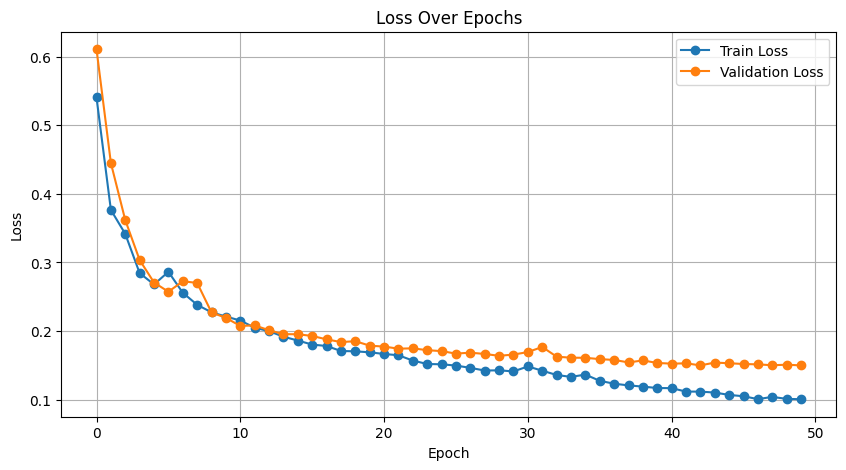

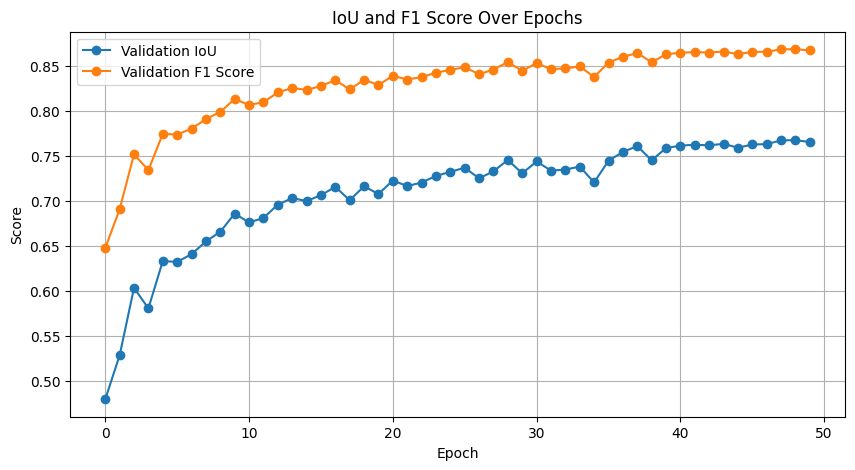

In [68]:
# Loss Chart
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# IoU & F1 Chart
plt.figure(figsize=(10, 5))
plt.plot(val_ious, label='Validation IoU', marker='o')
plt.plot(val_f1s, label='Validation F1 Score', marker='o')
plt.title("IoU and F1 Score Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()

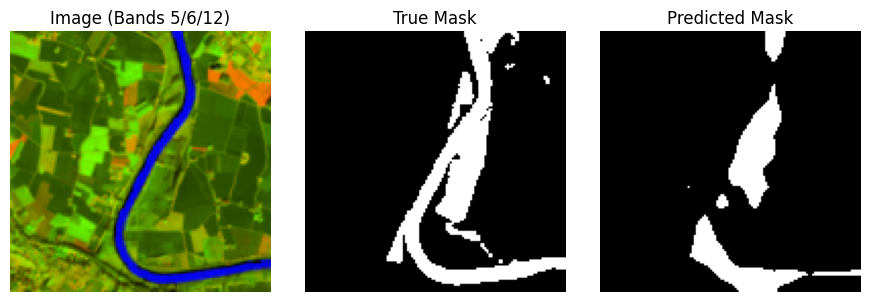

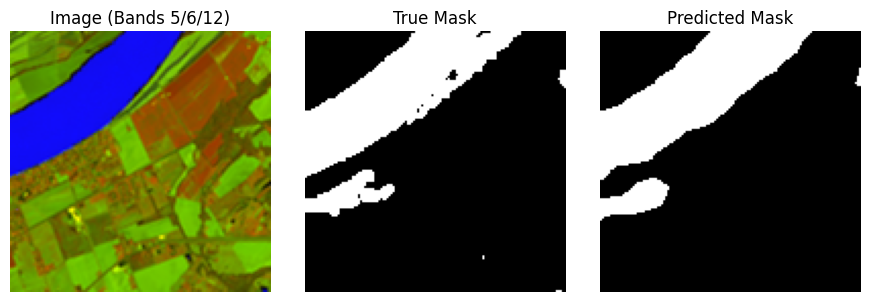

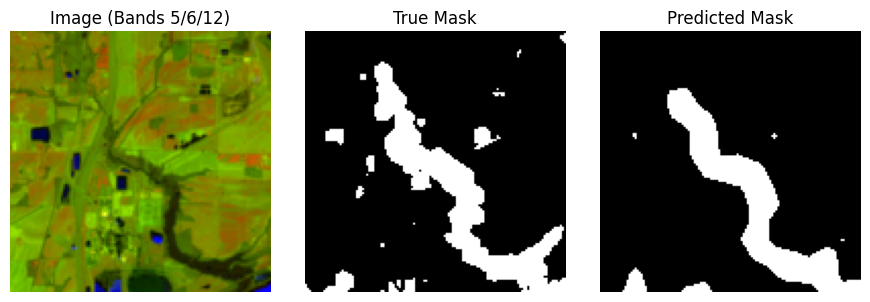

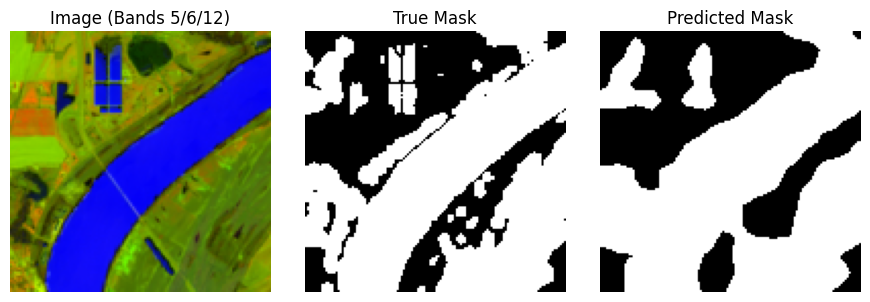

In [69]:
model_DLV3.eval()
with torch.no_grad():
    for images, masks in val_loader_aug:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model_DLV3(images)
        preds = torch.sigmoid(outputs)
        preds = (preds > 0.5).float()

        for i in range(4):  # Show first 4 samples
            # Bands used: [5, 6, 12] → Channels 0, 1, 2
            rgb = images[i][[0, 1, 2]].cpu().permute(1, 2, 0).numpy()
            rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min() + 1e-6)  # Normalize to [0, 1]

            true_mask = masks[i][0].cpu().numpy()
            pred_mask = preds[i][0].cpu().numpy()

            plt.figure(figsize=(9, 3))
            plt.subplot(1, 3, 1)
            plt.title("Image (Bands 5/6/12)")
            plt.imshow(rgb)
            plt.axis("off")

            plt.subplot(1, 3, 2)
            plt.title("True Mask")
            plt.imshow(true_mask, cmap='gray')
            plt.axis("off")

            plt.subplot(1, 3, 3)
            plt.title("Predicted Mask")
            plt.imshow(pred_mask, cmap='gray')
            plt.axis("off")

            plt.tight_layout()
            plt.show()
        break


In [71]:
def compute_metrics(preds, targets, threshold=0.5):
    preds = torch.sigmoid(preds)
    preds = (preds > threshold).float()

    preds = preds.cpu().numpy().astype(int)
    targets = targets.cpu().numpy().astype(int)

    TP = (preds * targets).sum()
    TN = ((1 - preds) * (1 - targets)).sum()
    FP = (preds * (1 - targets)).sum()
    FN = ((1 - preds) * targets).sum()

    epsilon = 1e-7

    accuracy = (TP + TN) / (TP + TN + FP + FN + epsilon)
    precision = TP / (TP + FP + epsilon)
    recall = TP / (TP + FN + epsilon)
    f1 = 2 * (precision * recall) / (precision + recall + epsilon)
    iou = TP / (TP + FP + FN + epsilon)

    return accuracy, precision, recall, f1, iou

def evaluate_metrics(model, dataloader, device):
    model.eval()
    total_acc, total_prec, total_rec, total_f1, total_iou = 0, 0, 0, 0, 0
    n_batches = 0

    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            acc, prec, rec, f1, iou = compute_metrics(outputs, masks)

            total_acc += acc
            total_prec += prec
            total_rec += rec
            total_f1 += f1
            total_iou += iou
            n_batches += 1

    print("=== Evaluation Metrics ===")
    print(f"Accuracy : {total_acc / n_batches:.4f}")
    print(f"Precision: {total_prec / n_batches:.4f}")
    print(f"Recall   : {total_rec / n_batches:.4f}")
    print(f"F1-Score : {total_f1 / n_batches:.4f}")
    print(f"IoU      : {total_iou / n_batches:.4f}")



evaluate_metrics(model_DLV3, val_loader_aug, device)


=== Evaluation Metrics ===
Accuracy : 0.9424
Precision: 0.9053
Recall   : 0.8326
F1-Score : 0.8672
IoU      : 0.7655


# 🧠 Models and Encoders Overview

This project explores multiple semantic segmentation architectures using the `segmentation_models_pytorch (smp)` library. The goal was to compare their performance on satellite/multispectral imagery with 8 selected bands as input.

## 🧪 Models Used

### ✅ DeepLabV3
- Leverages **Atrous Spatial Pyramid Pooling (ASPP)** to capture multi-scale context.
- Suitable for segmenting **large-scale objects** in remote sensing images.

### ✅ UNet++ (Nested UNet)
- Enhanced with dense skip connections and deep supervision.
- Excels at **fine-grained segmentation** with better boundary refinement.

### ✅ PSPNet (Pyramid Scene Parsing Network)
- Uses **pyramid pooling** to gather global and local context.
- Effective for segmenting **objects at various scales** in a scene.

### ✅ FPN (Feature Pyramid Network)
- Builds a **top-down feature pyramid** with lateral connections.
- Great for **multi-scale segmentation**, especially in lightweight scenarios.

---

## 🧩 Encoders Used (Backbones)

To boost performance, the following pretrained encoders were used across the above models:

- **ResNet34** – A balanced encoder with moderate depth and good performance.
- **ResNet50** – A deeper variant offering richer feature representations.
- **MobileNetV2** – Lightweight and fast, ideal for low-resource environments.

---

## ⚙️ Common Configuration

- **Input Channels**: 8 selected bands `[5, 6, 12, 7, 9, 10, 11, 8]`
- **Image Size**: Resized to `256x256`
- **Loss Function**: `BCEWithLogitsLoss`
- **Optimizer**: `Adam` with `lr=1e-4`
- **Augmentations**: Horizontal/vertical flips, rotation, brightness, contrast (using Albumentations)
- **Tracking**: All training runs logged using **MLflow**

---

By experimenting with these models and encoders, this work aims to identify the optimal architecture for **accurate and efficient segmentation** of multispectral satellite data.


In [95]:
# ✅ Parameters
in_channels = 12
num_epochs = 50
lr = 1e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ Define the model
model_FPN  = smp.PSPNet(
    encoder_name="resnet50",        # You can try others like "efficientnet-b0"
    encoder_weights="imagenet",     # Use pretrained weights
    in_channels=in_channels,        # Number of input channels
    classes=1                       # Binary segmentation
).to(device)

# ✅ Define optimizer and loss
optimizer = optim.Adam(model_FPN .parameters(), lr=lr)
criterion = nn.BCEWithLogitsLoss()

# ✅ End any previous run
if mlflow.active_run():
    mlflow.end_run()

# ✅ Start new MLflow run
with mlflow.start_run(run_name="model_FPN"):

    # 📋 Log parameters
    mlflow.log_param("model", "model_FPN_resnet50")
    mlflow.log_param("in_channels", in_channels)
    mlflow.log_param("out_channels", 1)
    mlflow.log_param("epochs", num_epochs)
    mlflow.log_param("learning_rate", lr)
    mlflow.log_param("NOrm", "Min_Max")
    mlflow.log_param("Bands", "all")
    mlflow.log_param("loss_function", "BCEWithLogitsLoss")
    mlflow.log_param("optimizer", "Adam")
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("encoder_weights", "imagenet")
    mlflow.log_param("augmentation", "None")

    # 📊 Metric containers
    train_losses, val_losses, val_ious, val_f1s = [], [], [], []

    # 🔁 Training loop
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        # 🎯 Train
        train_loss = train_one_epoch(model_FPN, train_loader, optimizer, criterion, device)

        # 🧪 Validate
        val_loss, val_iou, val_acc, val_f1 = evaluate(model_FPN, val_loader, criterion, device)

        # 📉 Log to MLflow
        mlflow.log_metric("train_loss", train_loss, step=epoch)
        mlflow.log_metric("val_loss", val_loss, step=epoch)
        mlflow.log_metric("val_iou", val_iou, step=epoch)
        mlflow.log_metric("val_f1", val_f1, step=epoch)

        # ⬇️ Save metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_ious.append(val_iou)
        val_f1s.append(val_f1)

        # 🖨️ Show progress
        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | IoU: {val_iou:.4f} | F1: {val_f1:.4f}")

    # 💾 Save final model
    mlflow.pytorch.log_model(model_FPN, "model")


Epoch 1/50


100%|██████████| 8/8 [00:03<00:00,  2.04it/s]


Train Loss: 0.5451 | Val Loss: 0.5751 | IoU: 0.4248 | F1: 0.5939

Epoch 2/50


100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


Train Loss: 0.3226 | Val Loss: 0.4247 | IoU: 0.2766 | F1: 0.4291

Epoch 3/50


100%|██████████| 8/8 [00:04<00:00,  1.97it/s]


Train Loss: 0.2889 | Val Loss: 0.3413 | IoU: 0.3145 | F1: 0.4752

Epoch 4/50


100%|██████████| 8/8 [00:04<00:00,  1.85it/s]


Train Loss: 0.2532 | Val Loss: 0.2936 | IoU: 0.3842 | F1: 0.5521

Epoch 5/50


100%|██████████| 8/8 [00:03<00:00,  2.06it/s]


Train Loss: 0.2393 | Val Loss: 0.2382 | IoU: 0.5308 | F1: 0.6899

Epoch 6/50


100%|██████████| 8/8 [00:04<00:00,  1.74it/s]


Train Loss: 0.2269 | Val Loss: 0.2124 | IoU: 0.5961 | F1: 0.7447

Epoch 7/50


100%|██████████| 8/8 [00:05<00:00,  1.43it/s]


Train Loss: 0.2225 | Val Loss: 0.2036 | IoU: 0.6162 | F1: 0.7609

Epoch 8/50


100%|██████████| 8/8 [00:04<00:00,  1.73it/s]


Train Loss: 0.2166 | Val Loss: 0.1959 | IoU: 0.6488 | F1: 0.7861

Epoch 9/50


100%|██████████| 8/8 [00:03<00:00,  2.02it/s]


Train Loss: 0.2114 | Val Loss: 0.1865 | IoU: 0.6553 | F1: 0.7902

Epoch 10/50


100%|██████████| 8/8 [00:04<00:00,  1.86it/s]


Train Loss: 0.2036 | Val Loss: 0.1813 | IoU: 0.6716 | F1: 0.8022

Epoch 11/50


100%|██████████| 8/8 [00:03<00:00,  2.04it/s]


Train Loss: 0.2011 | Val Loss: 0.1815 | IoU: 0.6677 | F1: 0.8000

Epoch 12/50


100%|██████████| 8/8 [00:04<00:00,  2.00it/s]


Train Loss: 0.1963 | Val Loss: 0.1749 | IoU: 0.6848 | F1: 0.8120

Epoch 13/50


100%|██████████| 8/8 [00:04<00:00,  1.93it/s]


Train Loss: 0.1866 | Val Loss: 0.1756 | IoU: 0.6738 | F1: 0.8042

Epoch 14/50


100%|██████████| 8/8 [00:03<00:00,  2.07it/s]


Train Loss: 0.1856 | Val Loss: 0.1720 | IoU: 0.6948 | F1: 0.8192

Epoch 15/50


100%|██████████| 8/8 [00:04<00:00,  1.80it/s]


Train Loss: 0.1792 | Val Loss: 0.1682 | IoU: 0.6946 | F1: 0.8187

Epoch 16/50


100%|██████████| 8/8 [00:03<00:00,  2.03it/s]


Train Loss: 0.1782 | Val Loss: 0.1632 | IoU: 0.7047 | F1: 0.8258

Epoch 17/50


100%|██████████| 8/8 [00:04<00:00,  1.91it/s]


Train Loss: 0.1814 | Val Loss: 0.1652 | IoU: 0.6970 | F1: 0.8207

Epoch 18/50


100%|██████████| 8/8 [00:04<00:00,  1.98it/s]


Train Loss: 0.1794 | Val Loss: 0.1599 | IoU: 0.7154 | F1: 0.8335

Epoch 19/50


100%|██████████| 8/8 [00:03<00:00,  2.05it/s]


Train Loss: 0.1686 | Val Loss: 0.1588 | IoU: 0.7176 | F1: 0.8350

Epoch 20/50


100%|██████████| 8/8 [00:04<00:00,  1.84it/s]


Train Loss: 0.1696 | Val Loss: 0.1576 | IoU: 0.7206 | F1: 0.8367

Epoch 21/50


100%|██████████| 8/8 [00:03<00:00,  2.03it/s]


Train Loss: 0.1696 | Val Loss: 0.1547 | IoU: 0.7318 | F1: 0.8447

Epoch 22/50


100%|██████████| 8/8 [00:04<00:00,  1.78it/s]


Train Loss: 0.1712 | Val Loss: 0.1549 | IoU: 0.7237 | F1: 0.8392

Epoch 23/50


100%|██████████| 8/8 [00:04<00:00,  1.84it/s]


Train Loss: 0.1665 | Val Loss: 0.1564 | IoU: 0.7279 | F1: 0.8421

Epoch 24/50


100%|██████████| 8/8 [00:04<00:00,  1.82it/s]


Train Loss: 0.1603 | Val Loss: 0.1555 | IoU: 0.7226 | F1: 0.8386

Epoch 25/50


100%|██████████| 8/8 [00:03<00:00,  2.02it/s]


Train Loss: 0.1646 | Val Loss: 0.1584 | IoU: 0.7051 | F1: 0.8261

Epoch 26/50


100%|██████████| 8/8 [00:03<00:00,  2.02it/s]


Train Loss: 0.1741 | Val Loss: 0.1626 | IoU: 0.6919 | F1: 0.8172

Epoch 27/50


100%|██████████| 8/8 [00:04<00:00,  1.88it/s]


Train Loss: 0.1500 | Val Loss: 0.1546 | IoU: 0.7332 | F1: 0.8457

Epoch 28/50


100%|██████████| 8/8 [00:03<00:00,  2.06it/s]


Train Loss: 0.1497 | Val Loss: 0.1591 | IoU: 0.6949 | F1: 0.8190

Epoch 29/50


100%|██████████| 8/8 [00:05<00:00,  1.59it/s]


Train Loss: 0.1547 | Val Loss: 0.1482 | IoU: 0.7478 | F1: 0.8555

Epoch 30/50


100%|██████████| 8/8 [00:04<00:00,  1.98it/s]


Train Loss: 0.1501 | Val Loss: 0.1569 | IoU: 0.7055 | F1: 0.8268

Epoch 31/50


100%|██████████| 8/8 [00:04<00:00,  1.87it/s]


Train Loss: 0.1500 | Val Loss: 0.1476 | IoU: 0.7450 | F1: 0.8535

Epoch 32/50


100%|██████████| 8/8 [00:03<00:00,  2.03it/s]


Train Loss: 0.1418 | Val Loss: 0.1494 | IoU: 0.7393 | F1: 0.8499

Epoch 33/50


100%|██████████| 8/8 [00:04<00:00,  1.98it/s]


Train Loss: 0.1436 | Val Loss: 0.1481 | IoU: 0.7410 | F1: 0.8510

Epoch 34/50


100%|██████████| 8/8 [00:04<00:00,  1.81it/s]


Train Loss: 0.1439 | Val Loss: 0.1494 | IoU: 0.7338 | F1: 0.8462

Epoch 35/50


100%|██████████| 8/8 [00:03<00:00,  2.00it/s]


Train Loss: 0.1420 | Val Loss: 0.1456 | IoU: 0.7417 | F1: 0.8514

Epoch 36/50


100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


Train Loss: 0.1377 | Val Loss: 0.1429 | IoU: 0.7429 | F1: 0.8521

Epoch 37/50


100%|██████████| 8/8 [00:03<00:00,  2.03it/s]


Train Loss: 0.1355 | Val Loss: 0.1440 | IoU: 0.7446 | F1: 0.8534

Epoch 38/50


100%|██████████| 8/8 [00:04<00:00,  1.95it/s]


Train Loss: 0.1396 | Val Loss: 0.1522 | IoU: 0.7191 | F1: 0.8363

Epoch 39/50


100%|██████████| 8/8 [00:04<00:00,  1.99it/s]


Train Loss: 0.1355 | Val Loss: 0.1437 | IoU: 0.7503 | F1: 0.8572

Epoch 40/50


100%|██████████| 8/8 [00:03<00:00,  2.04it/s]


Train Loss: 0.1351 | Val Loss: 0.1493 | IoU: 0.7323 | F1: 0.8452

Epoch 41/50


100%|██████████| 8/8 [00:04<00:00,  1.78it/s]


Train Loss: 0.1325 | Val Loss: 0.1395 | IoU: 0.7596 | F1: 0.8632

Epoch 42/50


100%|██████████| 8/8 [00:03<00:00,  2.04it/s]


Train Loss: 0.1298 | Val Loss: 0.1393 | IoU: 0.7533 | F1: 0.8590

Epoch 43/50


100%|██████████| 8/8 [00:04<00:00,  1.82it/s]


Train Loss: 0.1305 | Val Loss: 0.1416 | IoU: 0.7476 | F1: 0.8553

Epoch 44/50


100%|██████████| 8/8 [00:04<00:00,  1.81it/s]


Train Loss: 0.1340 | Val Loss: 0.1383 | IoU: 0.7523 | F1: 0.8583

Epoch 45/50


100%|██████████| 8/8 [00:04<00:00,  1.96it/s]


Train Loss: 0.1258 | Val Loss: 0.1404 | IoU: 0.7534 | F1: 0.8591

Epoch 46/50


100%|██████████| 8/8 [00:04<00:00,  1.92it/s]


Train Loss: 0.1306 | Val Loss: 0.1435 | IoU: 0.7368 | F1: 0.8480

Epoch 47/50


100%|██████████| 8/8 [00:03<00:00,  2.03it/s]


Train Loss: 0.1322 | Val Loss: 0.1417 | IoU: 0.7527 | F1: 0.8587

Epoch 48/50


100%|██████████| 8/8 [00:04<00:00,  1.79it/s]


Train Loss: 0.1277 | Val Loss: 0.1404 | IoU: 0.7536 | F1: 0.8593

Epoch 49/50


100%|██████████| 8/8 [00:04<00:00,  1.91it/s]


Train Loss: 0.1241 | Val Loss: 0.1380 | IoU: 0.7653 | F1: 0.8669

Epoch 50/50


100%|██████████| 8/8 [00:06<00:00,  1.30it/s]
2025/08/01 20:12:27 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Train Loss: 0.1287 | Val Loss: 0.1386 | IoU: 0.7520 | F1: 0.8580


2025/08/01 20:12:27 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/08/01 20:12:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [96]:
    # Save model to .pth file locally
    model_path = "/content/drive/MyDrive/Water Segmentation/models/model_FPN50.pth"
    torch.save(model_FPN.state_dict(),model_path)
    mlflow.log_artifact(model_path)
    print("Model saved and logged to MLflow.")



Model saved and logged to MLflow.


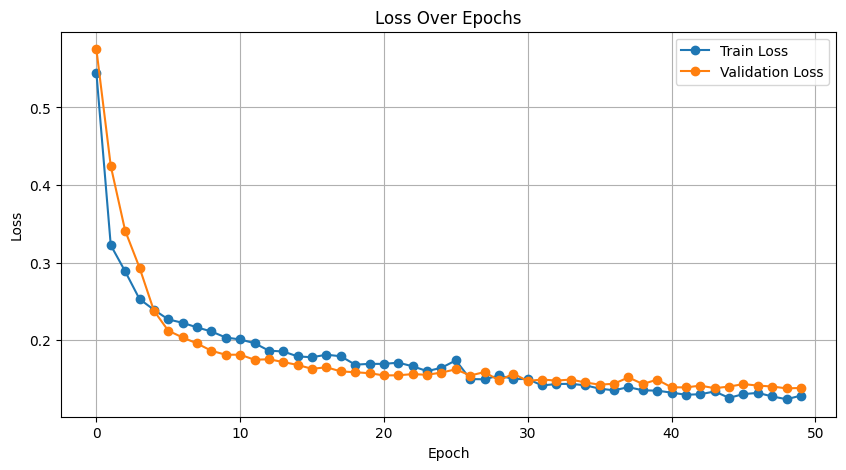

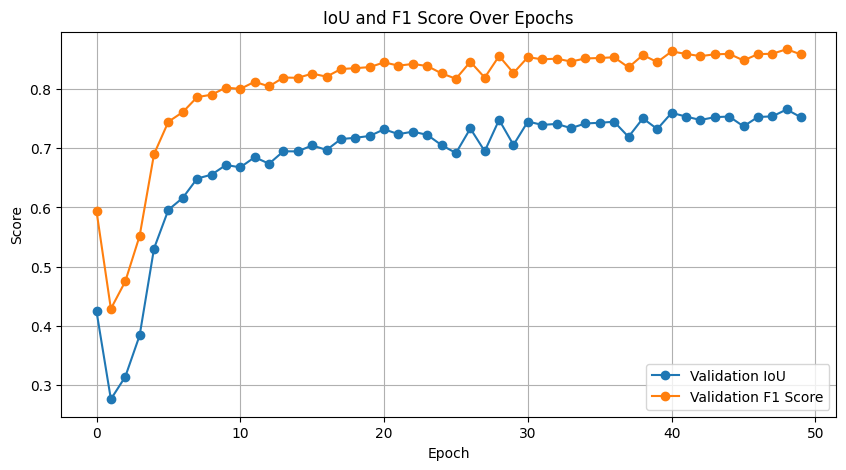

In [97]:
# Loss Chart
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# IoU & F1 Chart
plt.figure(figsize=(10, 5))
plt.plot(val_ious, label='Validation IoU', marker='o')
plt.plot(val_f1s, label='Validation F1 Score', marker='o')
plt.title("IoU and F1 Score Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()

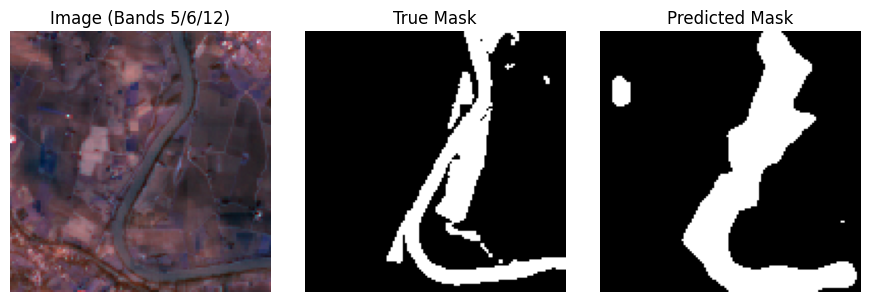

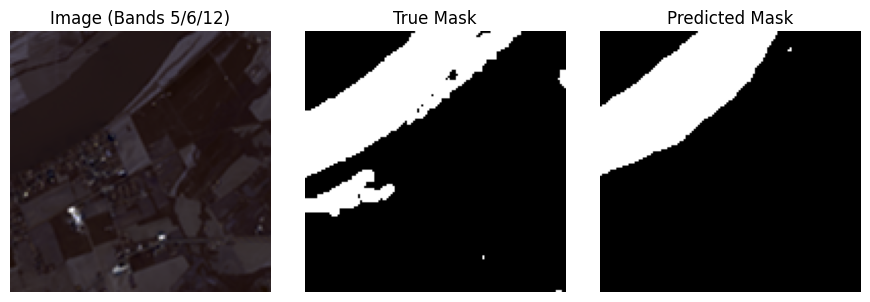

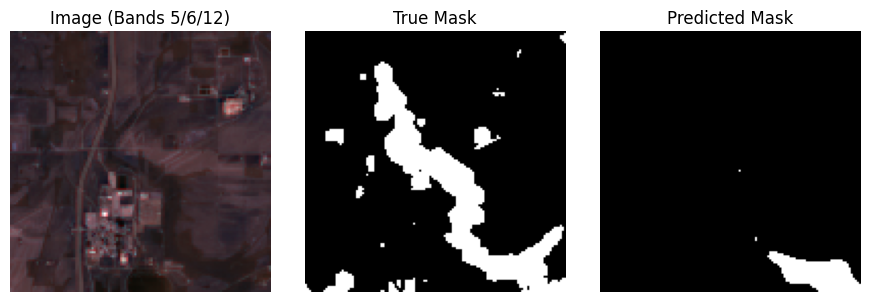

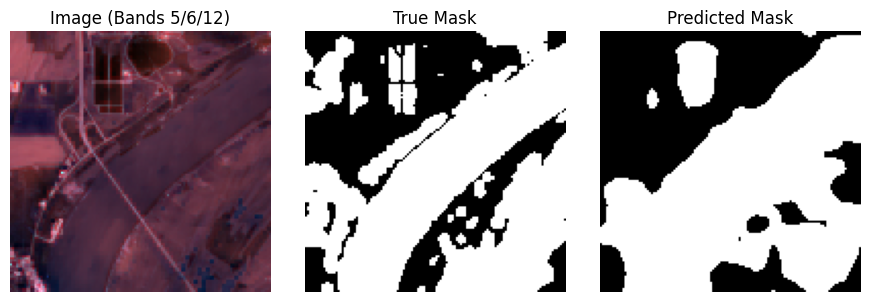

In [98]:
model_FPN.eval()
with torch.no_grad():
    for images, masks in val_loader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model_PSPNet(images)
        preds = torch.sigmoid(outputs)
        preds = (preds > 0.5).float()

        for i in range(4):  # Show first 4 samples
            # Bands used: [5, 6, 12] → Channels 0, 1, 2
            rgb = images[i][[0, 1, 2]].cpu().permute(1, 2, 0).numpy()
            rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min() + 1e-6)  # Normalize to [0, 1]

            true_mask = masks[i][0].cpu().numpy()
            pred_mask = preds[i][0].cpu().numpy()

            plt.figure(figsize=(9, 3))
            plt.subplot(1, 3, 1)
            plt.title("Image (Bands 5/6/12)")
            plt.imshow(rgb)
            plt.axis("off")

            plt.subplot(1, 3, 2)
            plt.title("True Mask")
            plt.imshow(true_mask, cmap='gray')
            plt.axis("off")

            plt.subplot(1, 3, 3)
            plt.title("Predicted Mask")
            plt.imshow(pred_mask, cmap='gray')
            plt.axis("off")

            plt.tight_layout()
            plt.show()
        break


In [100]:
def compute_metrics(preds, targets, threshold=0.5):
    preds = torch.sigmoid(preds)
    preds = (preds > threshold).float()

    preds = preds.cpu().numpy().astype(int)
    targets = targets.cpu().numpy().astype(int)

    TP = (preds * targets).sum()
    TN = ((1 - preds) * (1 - targets)).sum()
    FP = (preds * (1 - targets)).sum()
    FN = ((1 - preds) * targets).sum()

    epsilon = 1e-7

    accuracy = (TP + TN) / (TP + TN + FP + FN + epsilon)
    precision = TP / (TP + FP + epsilon)
    recall = TP / (TP + FN + epsilon)
    f1 = 2 * (precision * recall) / (precision + recall + epsilon)
    iou = TP / (TP + FP + FN + epsilon)

    return accuracy, precision, recall, f1, iou

def evaluate_metrics(model, dataloader, device):
    model.eval()
    total_acc, total_prec, total_rec, total_f1, total_iou = 0, 0, 0, 0, 0
    n_batches = 0

    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            acc, prec, rec, f1, iou = compute_metrics(outputs, masks)

            total_acc += acc
            total_prec += prec
            total_rec += rec
            total_f1 += f1
            total_iou += iou
            n_batches += 1

    print("=== Evaluation Metrics ===")
    print(f"Accuracy : {total_acc / n_batches:.4f}")
    print(f"Precision: {total_prec / n_batches:.4f}")
    print(f"Recall   : {total_rec / n_batches:.4f}")
    print(f"F1-Score : {total_f1 / n_batches:.4f}")
    print(f"IoU      : {total_iou / n_batches:.4f}")



evaluate_metrics(model_FPN, val_loader, device)


=== Evaluation Metrics ===
Accuracy : 0.9423
Precision: 0.9264
Recall   : 0.7992
F1-Score : 0.8580
IoU      : 0.7520


## 🔮 Future Work

### Exploring Advanced Architectures for Multispectral Segmentation

To further enhance segmentation performance on multispectral satellite imagery with 12 or more spectral bands, the following advanced architectures are proposed for exploration:

---

### 1. U-Net 3+

- Enhances the classic U-Net by adding **full-scale skip connections** that fuse features across all encoder and decoder layers.
- Expected to improve boundary precision and class consistency on multispectral data.
- Supports optional **deep supervision** and **classification-guided modules**.
- Requires integration of external open-source implementations as it's not in popular PyTorch segmentation libraries.

---

### 2. TransUNet

- Combines CNN-based feature extraction with Transformer modules to capture **long-range dependencies**.
- Particularly useful for multispectral data where complex spatial and spectral relationships exist.
- Can improve segmentation by modeling global context beyond local convolutional receptive fields.

---

### 3. Swin-Unet

- A Transformer-based U-Net variant using **shifted window attention**.
- Excels at capturing multi-scale features and long-range interactions in high-dimensional input data.
- Well-suited for complex segmentation tasks in remote sensing imagery.

---

### 4. HRNet (High-Resolution Network)

- Maintains high-resolution representations throughout the network.
- Effective for detailed segmentation on multispectral images.
- Available in some segmentation frameworks but may require custom adaptations for multispectral inputs.

---

### Implementation Considerations

- These architectures are generally more complex and computationally demanding; thus, experiments will require careful tuning and potentially more powerful hardware.
- Integration will involve adapting data loaders, augmentation pipelines, and training loops.
- Evaluation will include benchmarking IoU, F1-score, and inference speed compared to baseline models.

---

By exploring these state-of-the-art models, the project aims to push segmentation accuracy and robustness for multispectral remote sensing applications.
